# Améliorez le produit IA de votre start-up

Ingénieur IA au sein de la startup “Avis Restau”, qui met en relation des clients et des restaurants.
2 Objectifs:
 1. Détecter les sujets d’insatisfaction présents dans les commentaires postés sur la plateforme.
 2. Labelliser automatiquement les photos postées sur la plateforme. Par exemple, identifier les photos relatives à la nourriture, au décor dans le restaurant ou à l’extérieur du restaurant.

## Détecter les sujets d’insatisfaction présents dans les commentaires postés sur la plateforme

Pour cela, nous etudierons le jeu de données **yelp_academic_dataset_review.json**
Il s'agit ici de texte, et nous etudierons avec attention les ressources suivantes:
 - [Cours Openclassrooms](https://openclassrooms.com/fr/courses/4470541-analysez-vos-donnees-textuelles)
 - [Librairies NLTK](https://www.nltk.org/)
 - [Introduction au Natural Language Toolkit (NLTK)](https://code.tutsplus.com/fr/tutorials/introducing-the-natural-language-toolkit-nltk--cms-28620)

Voici les différentes étapes que nous déroulerons pour analyser les commentaires négatifs pour détecter les différents sujets d’insatisfaction
 - A. Sélection de quelques milliers de commentaires négatifs
 - B. Prétraitement des données textuelles
 - C. Utilisation de techniques de réduction de dimension
 - D. Visualisation des données de grandes dimensions afin de détecter des mots clés et sujets d’insatisfaction


In [1]:
import numpy as np
import pandas as pd
from pandas.plotting import parallel_coordinates
from pandas import json_normalize


%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import seaborn as sns
sns.set_theme()

import plotly.express as px
import tarfile
import json
import csv
import random

import pyLDAvis
import pyLDAvis.sklearn
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()

#Librairie de Tokenisation
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk import word_tokenize, pos_tag, pos_tag_sents
from nltk.tag.util import str2tuple

# Gensim
import gensim
from gensim import corpora, models
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.models.coherencemodel import CoherenceModel
from gensim.models.ldamodel import LdaModel

from joblib import dump, load
import pickle

from wordcloud import WordCloud
from PIL import Image

#Librairie de comptage
#from collections import Counter

from sklearn import decomposition
from sklearn.preprocessing import LabelEncoder

#pyLDAvis now also supports LDA application from scikit-learn
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, NMF


# Load environment variables from .env file
import os
from dotenv import load_dotenv
load_dotenv("API_key.env")  # take environment variables from .env.
YELP_CLIENT_ID = os.getenv("YELP_CLIENT_ID")
YELP_API_KEY = os.getenv("YELP_API_KEY")


from yelpapi import YelpAPI
from gql import gql, Client
from gql.transport.requests import RequestsHTTPTransport
from gql.transport.aiohttp import AIOHTTPTransport
import requests

import argparse
from pprint import pprint

C:\Users\blanc\anaconda3\envs\IA_Project6bis\lib\site-packages\scipy\sparse\sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


In [2]:
# #fname = "./yelp_photos(1).tar"
# #fname = "./yelp_dataset(2).tar"
# if fname.endswith("tar.gz"):
#     tar = tarfile.open(fname, "r:gz")
#     tar.extractall()
#     tar.close()
# elif fname.endswith("tar"):
#     tar = tarfile.open(fname, "r:")
#     tar.extractall()
#     tar.close()

## Création des fonctions

### Creation des fonction pour Text (librairie NLTK)

In [3]:
# Init the Stopword language
stop = stopwords.words('english')

#Function to remove useless words 
def stopwords_text(df, column):
    #df['stopwords_text'] = df[column].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
    df['stopwords_text'] = df.loc[:,column].apply(lambda x: [w for w in x if not w in stop and w.isalpha()])
    return (df)

# Init the Wordnet Lemmatizer
lemmatizer = nltk.stem.WordNetLemmatizer()

#Function to lemmatize text (Generic representation of words)
def lemmatize_text(df, column):
    #df['lemmatized_text'] = df.apply(lambda row: lemmatizer.lemmatize(row[column]), axis=1)
    df['lemmatized_text'] = df[column].apply(lambda x: [lemmatizer.lemmatize(w) for w in x])
    #df['lemmatized_text'] = df.loc[:,column].apply(lambda x: [lemmatizer.lemmatize(w) for w in x])
    return (df)

# Init the Tokenizer
tokenizer = nltk.RegexpTokenizer(r'\w+')

#Function to tokenize text (split in array)
def tokenize_text(df, column):
    df['tokenized_text'] = df.apply(lambda row: tokenizer.tokenize(row[column]), axis=1)
    #df['tokenized_text'] = df.apply(lambda row: tokenizer.tokenize(row[column]))
    return (df)

def remove_undesired_wordtag(df, column, tag_type_to_eliminate):
    #df['removed_tag_text'] = df.apply(lambda row: pos_tag(row[column]), axis=1)
    df['removed_tag_text'] = df.apply(lambda row: ([s[0] for s in pos_tag(row[column]) if s[1] not in tag_type_to_eliminate]), axis=1)
    return df

### Creation des fonction pour modéliser des sujets avec des méthodes non supervisées

In [4]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic {}:".format(topic_idx))
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

def get_descriptor(terms, H, topic_index, top ):
    # reverse sort the values to sort the indices
    top_indices = np.argsort( H[topic_index,:] )[::-1]
    # now get the terms corresponding to the top-ranked indices
    top_terms = []
    for term_index in top_indices[0:top]:
        top_terms.append(terms[term_index])
    return top_terms

def plot_top_term_weights( terms, H, topic_index, top ):
    # get the top terms and their weights
    top_indices = np.argsort( H[topic_index,:] )[::-1]
    top_terms = []
    top_weights = []
    for term_index in top_indices[0:top]:
        top_terms.append( terms[term_index] )
        top_weights.append( H[topic_index,term_index] )
    # note we reverse the ordering for the plot
    top_terms.reverse()
    top_weights.reverse()
    # create the plot
    fig = plt.figure(figsize=(13,8))
    # add the horizontal bar chart
    ypos = np.arange(top)
    ax = plt.barh(ypos, top_weights, align="center", tick_label=top_terms)
    plt.xlabel("Term Weight",fontsize=10)
    plt.ylabel("Word",fontsize=10)
    plt.title(f"Top {top} words from topic {topic_index}",fontsize=14)
    plt.tight_layout()
    plt.show()
    


### Création des fonctions d'analyse et de visualisation de données

In [5]:
#Create functions

def clean_data(data): 
    #Remove rows where important information are missing:
    data = data.dropna(axis = 0, how='all')
    #Clean duplicates
    data = data.drop_duplicates()
    #Change content in lowercase
    data = data.apply(lambda x: x.str.lower() if(x.dtype == 'object') else x)
    #Filter order_dataset


def colors_from_values(values, palette_name):
    # normalize the values to range [0, 1]
    normalized = (values - min(values)) / (max(values) - min(values))
    # convert to indices
    indices = np.round(normalized * (len(values) - 1)).astype(np.int32)
    # use the indices to get the colors
    palette = sns.color_palette(palette_name, len(values))
    return np.array(palette).take(indices, axis=0)
#ax = sns.barplot(data=data, x='indice', y='value', palette=colors_from_values(data['value'], "Greens_d"))

#Function to plot distribution of dates
def plot_peryearmonth(data: pd.DataFrame, date_column, plot_hue: bool, hue_column):
    data['date_yearmonth'] = pd.to_datetime(data[date_column]).dt.to_period('M')
    plt.figure(figsize=(15,10))
    if (plot_hue == True):
        ax1 = sns.countplot(x="date_yearmonth", data=data.sort_values('date_yearmonth'), hue=hue_column)
    else:
        ax1 = sns.countplot(x="date_yearmonth", data=data.sort_values('date_yearmonth'))
    ax1.set_title(f'Distribution of {date_column} per month')
    ax1.set_xticklabels(ax1.get_xticklabels(), rotation=40, ha="right")
    plt.tight_layout()
    plt.show()

def pairplot_columns(data: pd.DataFrame, colunms_selected: list, plot_hue: bool, hue_column):
    #fig, ax = plt.subplots(figsize=(15,10))
    if (plot_hue == True):
        ax = sns.pairplot(data[colunms_selected], 
                             hue=hue_column, 
                             hue_order=sorted(data[hue_column].unique(),
                             reverse=True)
                            )
    else:
        ax = ax=sns.pairplot(data[colunms_selected]
                            )
    ax.fig.suptitle(f'Pairplot on selected columns')
    plt.title(f'Pairplot on selected columns {colunms_selected}')
    plt.show()

    
#Function to plot Fill ratio in specified columns
def plot_fill_ratio(data: pd.DataFrame, colunms_selected: list):
    data_fill_ratio = pd.DataFrame(columns=['column_name', 'null_count', 'notnull_count'])
    data_fill_ratio.drop(data_fill_ratio.index, inplace=True)        
    for col in colunms_selected: 
        null_count = data[col].isna().sum()
        notnull_count = data[col].notna().sum()
        new_row = pd.DataFrame({'column_name':[col], 'null_count':[null_count], 'notnull_count':[notnull_count]})
        data_fill_ratio = pd.concat([data_fill_ratio, new_row], ignore_index = None, axis = 0)
    data_fill_ratio_study = pd.melt(data_fill_ratio.reset_index(), id_vars=['column_name'], value_vars=['null_count', 'notnull_count'])
    fig, ax = plt.subplots(figsize=(15,10))
    ax = sns.barplot(data=data_fill_ratio_study, x='value', y='column_name', hue='variable')
    ax.set_title('Null and NotNull Count per columns in dataframe')
    plt.show()
    data_fill_ratio_study.drop(data_fill_ratio_study.index, inplace=True)
    return(data_fill_ratio)

#Function to plot PIE Chart of n tops values in dataframe
def plot_ntops_pie(data: pd.DataFrame, colunm_name, ntops: int, plot_others: bool, plot_na: bool):
    podium_tops = pd.DataFrame(data[colunm_name].value_counts(dropna=True, sort=True).head(ntops))
    if (plot_others == True):
        remainings_counts = sum(data[colunm_name].value_counts(dropna=True)[ntops:])
        remainings_below = pd.DataFrame({colunm_name : [remainings_counts]}, index=['others'])
        podium_tops = pd.concat([podium_tops, remainings_below], ignore_index = None, axis = 0)
    if (plot_na == True):
        na_counts = data[colunm_name].isna().sum()
        remainings_na = pd.DataFrame({colunm_name : [na_counts]}, index=['NAN'])
        podium_tops = pd.concat([podium_tops, remainings_na], ignore_index = None, axis = 0)
    
    #Définir la taille du graphique
    plt.figure(figsize=(8,8))
    #Définir lae type du graphique, ici PIE CHart avec en Labels l'index du nom des libelle
    #l'autopct sert ici à afficher le % calculé avec 1 décimal derriere la virgule
    plt.pie(podium_tops[colunm_name], labels=podium_tops.index, autopct='%1.1f%%')
    #Afficher la légende en dessous du graphique au centre
    plt.legend(loc='upper left', bbox_to_anchor=(0.1, -0.01), fancybox=True, shadow=None, ncol=2)
    plt.title(f"{ntops} most presents values identified in column {colunm_name} .\nTOTAL unique = {len(data[colunm_name].unique())}")
    #Afficher le graphique
    plt.show()
    return(podium_tops)

def plot_ntops_bar(data: pd.DataFrame, colunm_name, ntops: int, plot_others: bool, plot_na: bool):
    podium_tops = pd.DataFrame(data[colunm_name].value_counts(dropna=True, sort=True).head(ntops))
    if (plot_others == True):
        remainings_counts = sum(data[colunm_name].value_counts(dropna=True)[ntops:])
        remainings_below = pd.DataFrame({colunm_name : [remainings_counts]}, index=['others'])
        podium_tops = pd.concat([podium_tops, remainings_below], ignore_index = None, axis = 0)
    if (plot_na == True):
        na_counts = data[colunm_name].isna().sum()
        remainings_na = pd.DataFrame({colunm_name : [na_counts]}, index=['NAN'])
        podium_tops = pd.concat([podium_tops, remainings_na], ignore_index = None, axis = 0)
    #Définir la taille du graphique
    fig, ax = plt.subplots(figsize=(15,10))
    #Définir lae type du graphique, ici BARPLOT avec en Labels l'index du nom des libelle
    ax = sns.barplot(data=podium_tops, x=podium_tops.index, y=colunm_name)
    plt.title(f"{ntops} most presents values identified in column {colunm_name} .\nTOTAL unique = {len(data[colunm_name].unique())}")
    #Afficher le graphique
    plt.show()
    return(podium_tops)

#Function to plot occurence by value present in specified column
def plot_occurence_line(data: pd.DataFrame, colunm_name):
    fig = px.line(data[colunm_name].value_counts())
    fig.update_layout(
        title_text=f"Number of occurence by {colunm_name} .\nTOTAL = {len(data[colunm_name])}",
        width=900,
        height=600,
        #markers=True,
    )
    fig.show()
    
#Create function that study boxplot
def plot_boxplot(data: pd.DataFrame, x_axis, colunms_selected: list, plot_outliers: bool): 
    for col in colunms_selected:
        sns.set()
        fig, ax = plt.subplots(figsize=(15, 5))
        sns.boxplot(x=x_axis, 
                    y=col, # column is chosen here
                    data=data,
                    #order=["a", "b"],
                    showfliers = plot_outliers,
                    showmeans=True,
                    )  
        sns.despine(offset=10, trim=True) 
        plt.title(f"Column {col} boxplot per {x_axis}")
        plt.show()

### Analyse des données

#### Récupération du corpus Review

In [6]:
#Definir le nombre de lignes à importer depuis le fichier JSON
n = 200000

In [7]:
review = []
with open('./dataset/yelp_academic_dataset_review.json', encoding="utf8") as fl:
    for i, line in enumerate(fl):
        review.append(json.loads(line))
        if i+1 >= n:
            break
review_df = pd.DataFrame(review)
print(review_df.shape)

(200000, 9)


In [8]:
review_df.info()
#review_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   review_id    200000 non-null  object 
 1   user_id      200000 non-null  object 
 2   business_id  200000 non-null  object 
 3   stars        200000 non-null  float64
 4   useful       200000 non-null  int64  
 5   funny        200000 non-null  int64  
 6   cool         200000 non-null  int64  
 7   text         200000 non-null  object 
 8   date         200000 non-null  object 
dtypes: float64(1), int64(3), object(5)
memory usage: 13.7+ MB


### Exploration des données

In [9]:
review_df.describe(include="all", datetime_is_numeric=True)

,review_id,user_id,business_id,stars,useful,funny,cool,text,date
count,200000,200000,200000,200000.000000,200000.000000,200000.000000,200000.000000,200000,200000
unique,200000,143686,11451,NaN,NaN,NaN,NaN,199816,199818
top,KU_O5udG6zpxOg-VcAEodg,_BcWyKQL16ndpBdggh2kNA,GBTPC53ZrG1ZBY3DT8Mbcw,NaN,NaN,NaN,NaN,Super cheap food for the amount you get! They ...,2015-05-02 02:13:32
freq,1,123,1859,NaN,NaN,NaN,NaN,3,3
mean,NaN,NaN,NaN,3.841425,0.901890,0.257635,0.349225,NaN,NaN
std,NaN,NaN,NaN,1.357044,2.062767,1.002639,1.077559,NaN,NaN
min,NaN,NaN,NaN,1.000000,0.000000,0.000000,0.000000,NaN,NaN
25%,NaN,NaN,NaN,3.000000,0.000000,0.000000,0.000000,NaN,NaN
50%,NaN,NaN,NaN,4.000000,0.000000,0.000000,0.000000,NaN,NaN
75%,NaN,NaN,NaN,5.000000,1.000000,0.000000,0.000000,NaN,NaN


#### Etude des colonnes 


C:\Users\blanc\anaconda3\envs\IA_Project6bis\lib\site-packages\seaborn\categorical.py:381: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) < "3.0":
C:\Users\blanc\anaconda3\envs\IA_Project6bis\lib\site-packages\setuptools\_distutils\version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


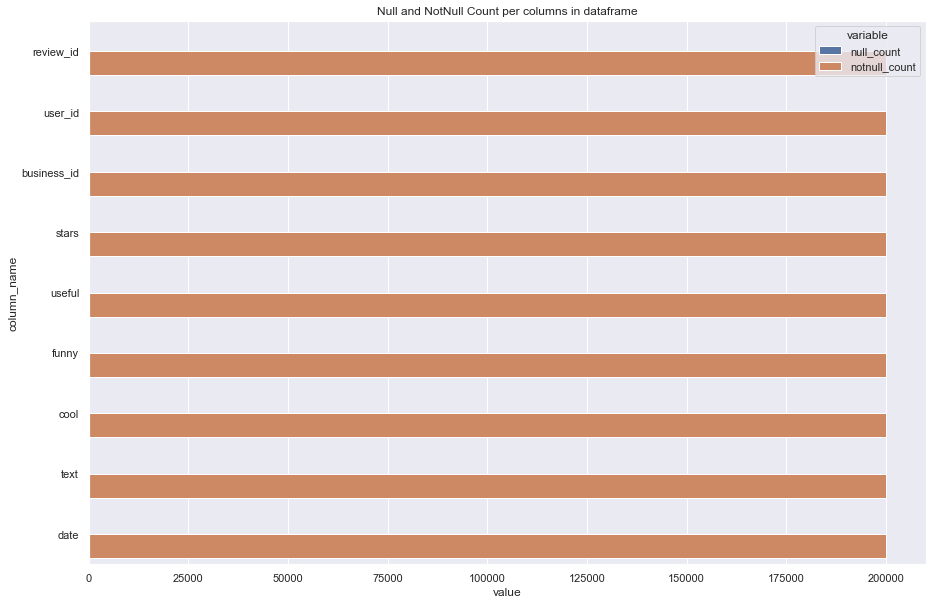

,column_name,null_count,notnull_count
0,review_id,0,200000
0,user_id,0,200000
0,business_id,0,200000
0,stars,0,200000
0,useful,0,200000
0,funny,0,200000
0,cool,0,200000
0,text,0,200000
0,date,0,200000


In [10]:
clean_data(review_df)
plot_fill_ratio(review_df, review_df.columns)

#### Etude de la distribution par date

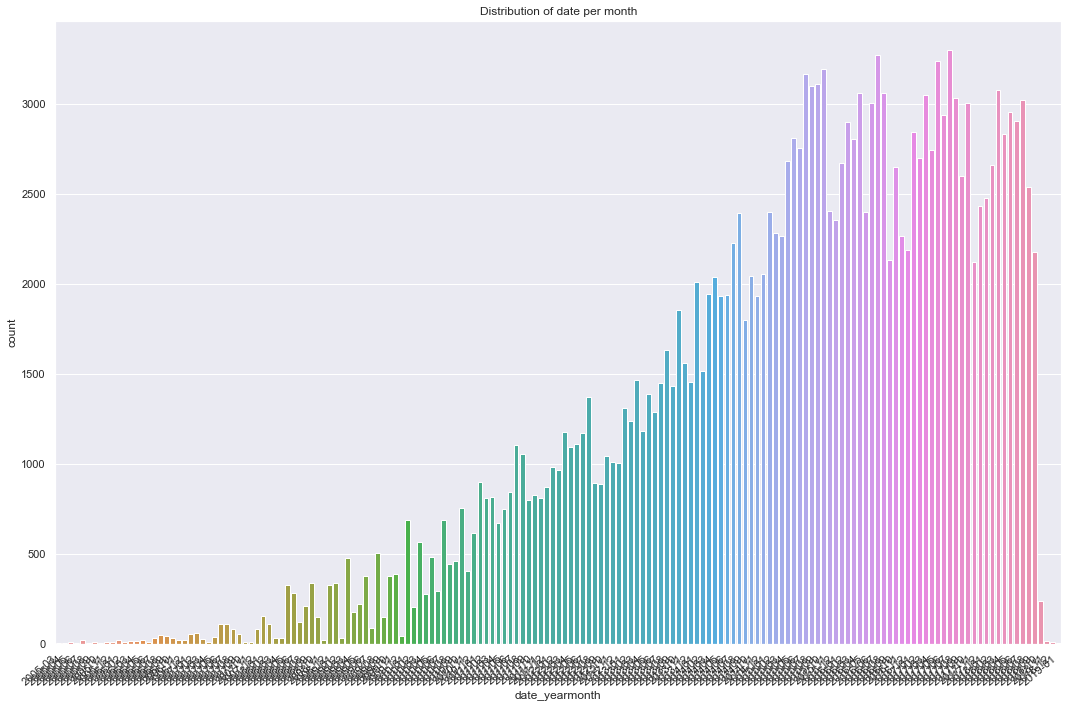

In [11]:
plot_peryearmonth(review_df, 'date', False, 'stars')
#This function is using countplot

#### Etude des évaluations / notes


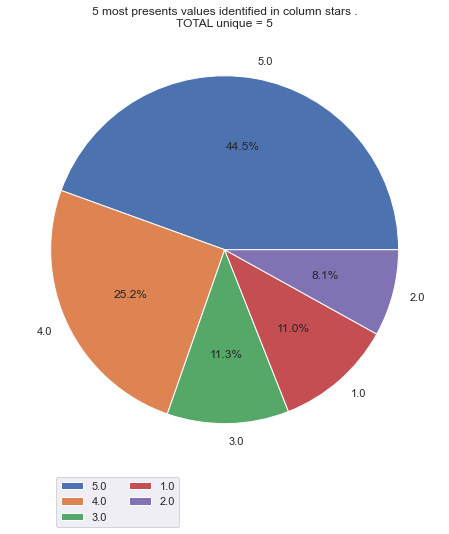

,stars
5.0,88931
4.0,50383
3.0,22648
1.0,21922
2.0,16116


In [12]:
plot_ntops_pie(review_df, 'stars', 5, False, False)

#### Etude des business_id 

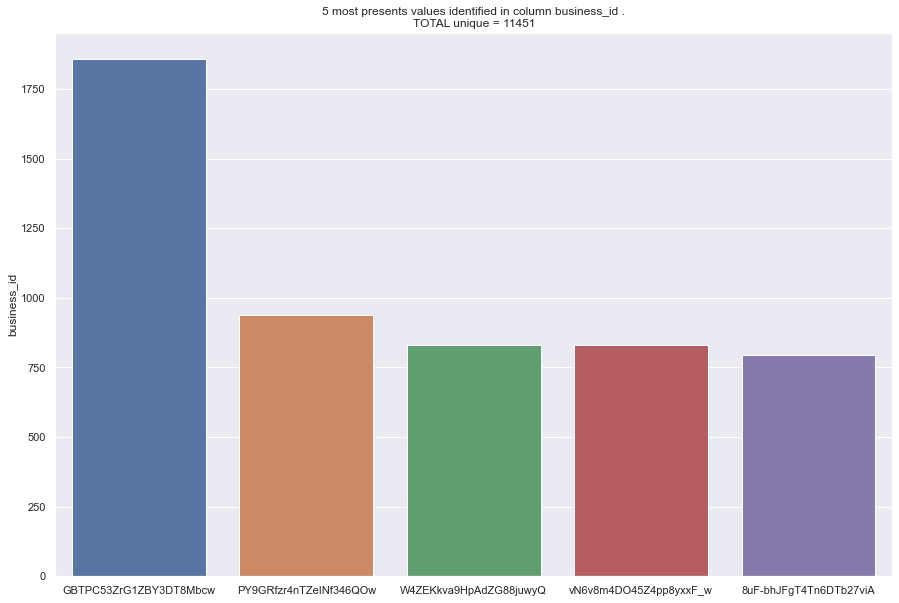

,business_id
GBTPC53ZrG1ZBY3DT8Mbcw,1859
PY9GRfzr4nTZeINf346QOw,940
W4ZEKkva9HpAdZG88juwyQ,831
vN6v8m4DO45Z4pp8yxxF_w,831
8uF-bhJFgT4Tn6DTb27viA,796


In [13]:
plot_ntops_bar(review_df, 'business_id', 5, False, False)

C:\Users\blanc\anaconda3\envs\IA_Project6bis\lib\site-packages\seaborn\rcmod.py:400: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
C:\Users\blanc\anaconda3\envs\IA_Project6bis\lib\site-packages\setuptools\_distutils\version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


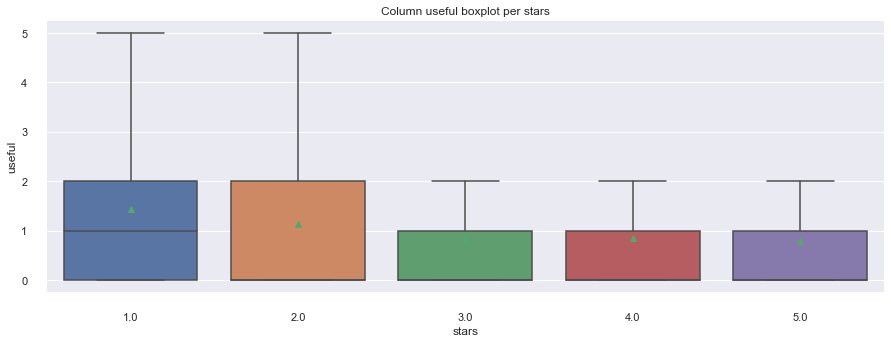

C:\Users\blanc\anaconda3\envs\IA_Project6bis\lib\site-packages\seaborn\rcmod.py:400: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
C:\Users\blanc\anaconda3\envs\IA_Project6bis\lib\site-packages\setuptools\_distutils\version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


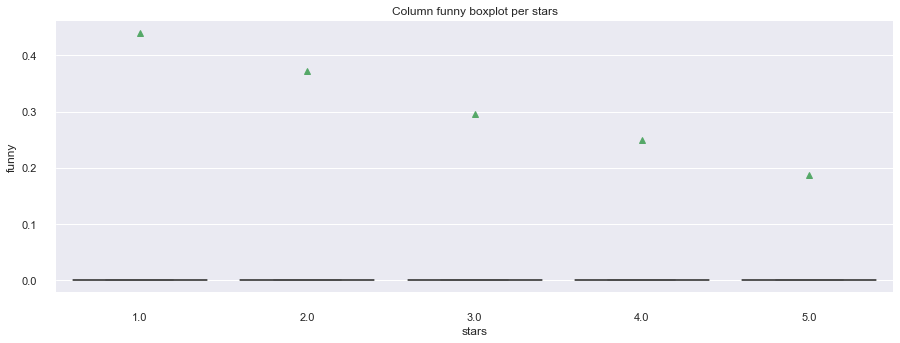

C:\Users\blanc\anaconda3\envs\IA_Project6bis\lib\site-packages\seaborn\rcmod.py:400: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
C:\Users\blanc\anaconda3\envs\IA_Project6bis\lib\site-packages\setuptools\_distutils\version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


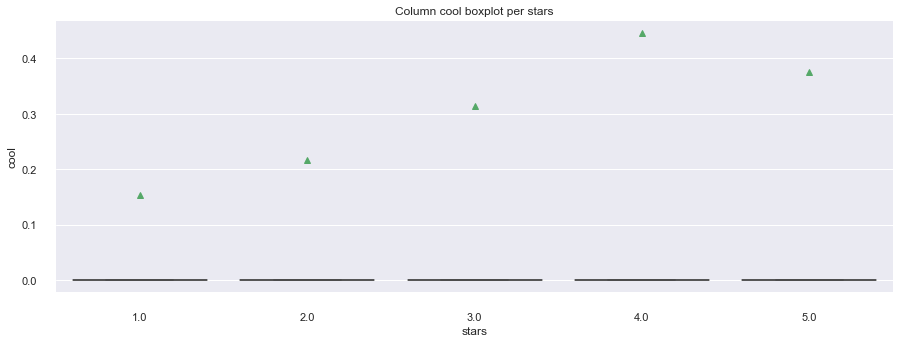

In [14]:
boxplot_columns = ['useful', 'funny', 'cool']
plot_boxplot(review_df, 'stars', boxplot_columns, False)

C:\Users\blanc\anaconda3\envs\IA_Project6bis\lib\site-packages\seaborn\axisgrid.py:130: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) < LooseVersion("3.0"):
C:\Users\blanc\anaconda3\envs\IA_Project6bis\lib\site-packages\seaborn\axisgrid.py:130: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) < LooseVersion("3.0"):


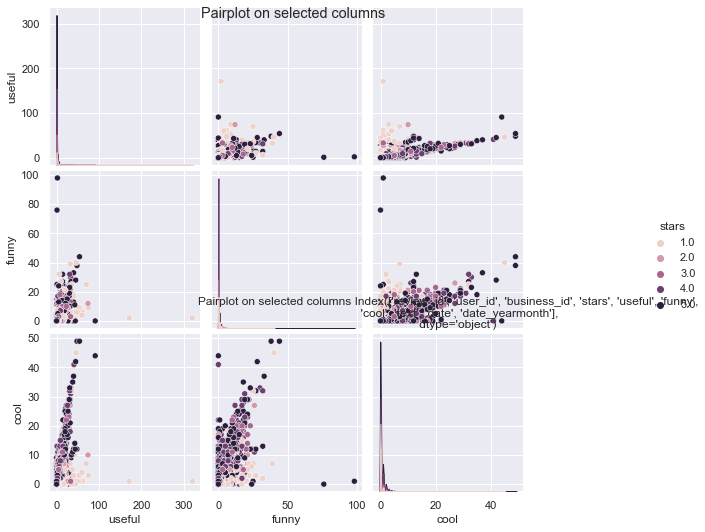

In [15]:
pairplot_columns(review_df, review_df.columns, True, 'stars')

C:\Users\blanc\anaconda3\envs\IA_Project6bis\lib\site-packages\seaborn\matrix.py:302: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  mesh = ax.pcolormesh(self.plot_data, cmap=self.cmap, **kws)
C:\Users\blanc\anaconda3\envs\IA_Project6bis\lib\site-packages\seaborn\matrix.py:312: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cb = ax.figure.colorbar(mesh, cax, ax, **self.cbar_kws)


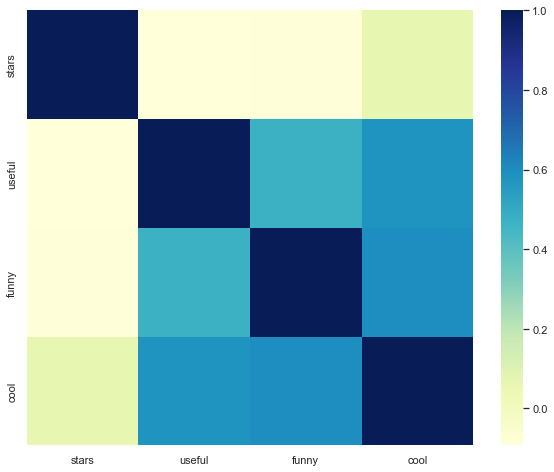

In [16]:
columns_values = ['stars', 'useful', 'funny', 'cool']
review_df_matrix = review_df[columns_values].corr()

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(review_df_matrix, cmap="YlGnBu")
plt.show()

Il n'y a pas de corrélation évidentes entre les notations clients, et les valeurs des colonne useful, funny et cool

### Selection de commentaires négatifs
#### Filtrage et Selection des insatisfaction

In [11]:
unsatisfied_max_score = 2.0
satisfaction_columns = ['stars', 'text']
unsatisfied_review_df = review_df.loc[(review_df['stars'] <= unsatisfied_max_score), satisfaction_columns]
unsatisfied_review_df

,stars,text
5,1.0,I am a long term frequent customer of this est...
29,2.0,I at least have to give this restaurant two st...
41,2.0,"Straight to the point, it's cheap, it tastes a..."
46,2.0,NEVER AGAIN. This is a so called restaurant th...
47,1.0,If you want to pay for everything a la carte t...
...,...,...
199975,2.0,The whole place has just a few souvenir stores...
199976,2.0,Sorry Spiro's I didn't want to say anything ba...
199987,1.0,This place sucks. We ordered food for deliver...
199991,1.0,I spoke with Keri about a month ago on the pho...


### Prétraitement des données textuelles
#### Nettoyage des Mots (StopWords et Lemmatization) et Découpage (Tokenisation)

 - Nettoyage inspiré du [tutoriel NLP](https://inside-machinelearning.com/preprocessing-nlp-tutoriel-pour-nettoyer-rapidement-un-texte/)
 - Classification de texte inspirée du [tutoriel TAL](https://www.actuia.com/contribution/victorbigand/tutoriel-tal-pour-les-debutants-classification-de-texte/)
 
Rappel: [NLP pour Natural Language Processing](https://www.youtube.com/watch?v=SCs8N_-t3cE), est une branche à part entière de l’IA qui permet de réaliser plusieurs tâches :
   - Traduction de texte
   - Résumé automatique de texte
   - Analyse de sentiment
   - Reconnaissance d’entités nommées (ex : nom propre ou lieu)

Lors de l'étape suivante, nous allons réaliser les étapes suivantes de pre-processing du jeu de donnée:
1. Passer le texte en Minuscule
2. Supprimer les élements de ponctuation
3. Supprimer les chiffres en digits
4. Tokeniser le texte (Split par mot/élement)
5. Supprimer les StopWords
6. Retrouver la racine par Lemmaization


In [12]:
# Change Text column to lower case
unsatisfied_review_df['text'] = unsatisfied_review_df['text'].str.lower()
# Replace punct by blank
unsatisfied_review_df['text'] = unsatisfied_review_df['text'].str.replace(r'[^\w\s]+', '', regex=True)
# Remove numbers digits from text column
unsatisfied_review_df['text_only'] = unsatisfied_review_df['text'].str.replace(r'[\d]+', '', regex=True)
# Words splitting
tokenize_text(unsatisfied_review_df, 'text_only')
# Words cleaning
stopwords_text(unsatisfied_review_df, 'tokenized_text')
lemmatize_text(unsatisfied_review_df, 'stopwords_text')
unsatisfied_review_df.head()


,stars,text,text_only,tokenized_text,stopwords_text,lemmatized_text
5,1.0,i am a long term frequent customer of this est...,i am a long term frequent customer of this est...,"[i, am, a, long, term, frequent, customer, of,...","[long, term, frequent, customer, establishment...","[long, term, frequent, customer, establishment..."
29,2.0,i at least have to give this restaurant two st...,i at least have to give this restaurant two st...,"[i, at, least, have, to, give, this, restauran...","[least, give, restaurant, two, stars, due, dec...","[least, give, restaurant, two, star, due, dece..."
41,2.0,straight to the point its cheap it tastes and ...,straight to the point its cheap it tastes and ...,"[straight, to, the, point, its, cheap, it, tas...","[straight, point, cheap, tastes, feels, cheap,...","[straight, point, cheap, taste, feel, cheap, g..."
46,2.0,never again this is a so called restaurant tha...,never again this is a so called restaurant tha...,"[never, again, this, is, a, so, called, restau...","[never, called, restaurant, nothing, restauran...","[never, called, restaurant, nothing, restauran..."
47,1.0,if you want to pay for everything a la carte t...,if you want to pay for everything a la carte t...,"[if, you, want, to, pay, for, everything, a, l...","[want, pay, everything, la, carte, place, food...","[want, pay, everything, la, carte, place, food..."


In [13]:
#Création du bag of words
unsatisfied_review_df['thesaurus'] = unsatisfied_review_df.loc[:,'lemmatized_text'].apply(lambda x: " ".join(x))
unsatisfied_review_df['thesaurus']

5         long term frequent customer establishment went...
29        least give restaurant two star due decent food...
41        straight point cheap taste feel cheap good pri...
46        never called restaurant nothing restaurant pre...
47        want pay everything la carte place food wasnt ...
                                ...                        
199975    whole place souvenir store lot empty space unl...
199976    sorry spiros didnt want say anything bad speak...
199987    place suck ordered food delivery showed faster...
199991    spoke keri month ago phone regarding selling c...
199993    hotel checked early without permission took be...
Name: thesaurus, Length: 38038, dtype: object

In [14]:
unsatisfied_review_df

,stars,text,text_only,tokenized_text,stopwords_text,lemmatized_text,thesaurus
5,1.0,i am a long term frequent customer of this est...,i am a long term frequent customer of this est...,"[i, am, a, long, term, frequent, customer, of,...","[long, term, frequent, customer, establishment...","[long, term, frequent, customer, establishment...",long term frequent customer establishment went...
29,2.0,i at least have to give this restaurant two st...,i at least have to give this restaurant two st...,"[i, at, least, have, to, give, this, restauran...","[least, give, restaurant, two, stars, due, dec...","[least, give, restaurant, two, star, due, dece...",least give restaurant two star due decent food...
41,2.0,straight to the point its cheap it tastes and ...,straight to the point its cheap it tastes and ...,"[straight, to, the, point, its, cheap, it, tas...","[straight, point, cheap, tastes, feels, cheap,...","[straight, point, cheap, taste, feel, cheap, g...",straight point cheap taste feel cheap good pri...
46,2.0,never again this is a so called restaurant tha...,never again this is a so called restaurant tha...,"[never, again, this, is, a, so, called, restau...","[never, called, restaurant, nothing, restauran...","[never, called, restaurant, nothing, restauran...",never called restaurant nothing restaurant pre...
47,1.0,if you want to pay for everything a la carte t...,if you want to pay for everything a la carte t...,"[if, you, want, to, pay, for, everything, a, l...","[want, pay, everything, la, carte, place, food...","[want, pay, everything, la, carte, place, food...",want pay everything la carte place food wasnt ...
...,...,...,...,...,...,...,...
199975,2.0,the whole place has just a few souvenir stores...,the whole place has just a few souvenir stores...,"[the, whole, place, has, just, a, few, souveni...","[whole, place, souvenir, stores, lots, empty, ...","[whole, place, souvenir, store, lot, empty, sp...",whole place souvenir store lot empty space unl...
199976,2.0,sorry spiros i didnt want to say anything bad ...,sorry spiros i didnt want to say anything bad ...,"[sorry, spiros, i, didnt, want, to, say, anyth...","[sorry, spiros, didnt, want, say, anything, ba...","[sorry, spiros, didnt, want, say, anything, ba...",sorry spiros didnt want say anything bad speak...
199987,1.0,this place sucks we ordered food for delivery...,this place sucks we ordered food for delivery...,"[this, place, sucks, we, ordered, food, for, d...","[place, sucks, ordered, food, delivery, showed...","[place, suck, ordered, food, delivery, showed,...",place suck ordered food delivery showed faster...
199991,1.0,i spoke with keri about a month ago on the pho...,i spoke with keri about a month ago on the pho...,"[i, spoke, with, keri, about, a, month, ago, o...","[spoke, keri, month, ago, phone, regarding, se...","[spoke, keri, month, ago, phone, regarding, se...",spoke keri month ago phone regarding selling c...


Nous notons malgrès tous la présence de mots très courant, qui n'ont probablement pas lieu d'être maintenu dans le dataset étudié.
Aussi, nous allons confirmer par le comptage des mots, et le nettoyage des plus fréquents.


#### Compter la fréquence d'apparition des mots

In [15]:
#From the Lemmatized text, split each word and create new dataframe counting word presence frequency
word_frequency = unsatisfied_review_df.thesaurus.str.split(expand=True).stack().value_counts()

word_frequency = pd.DataFrame({'word':word_frequency.index, 'word_count':word_frequency.values})

#For each word, determne its TAG type
word_frequency['word_tag'] = word_frequency['word'].apply(lambda x: nltk.pos_tag([x])[0][1])


In [16]:
unsatisfied_review_df.thesaurus.str.split(expand=True).stack()

5       0              long
        1              term
        2          frequent
        3          customer
        4     establishment
                  ...      
199993  40             mind
        41           future
        42            hotel
        43           choice
        44             make
Length: 2373714, dtype: object

In [17]:
# Print Word_tag distribution
#plot_occurence_line(word_frequency, 'word_tag')

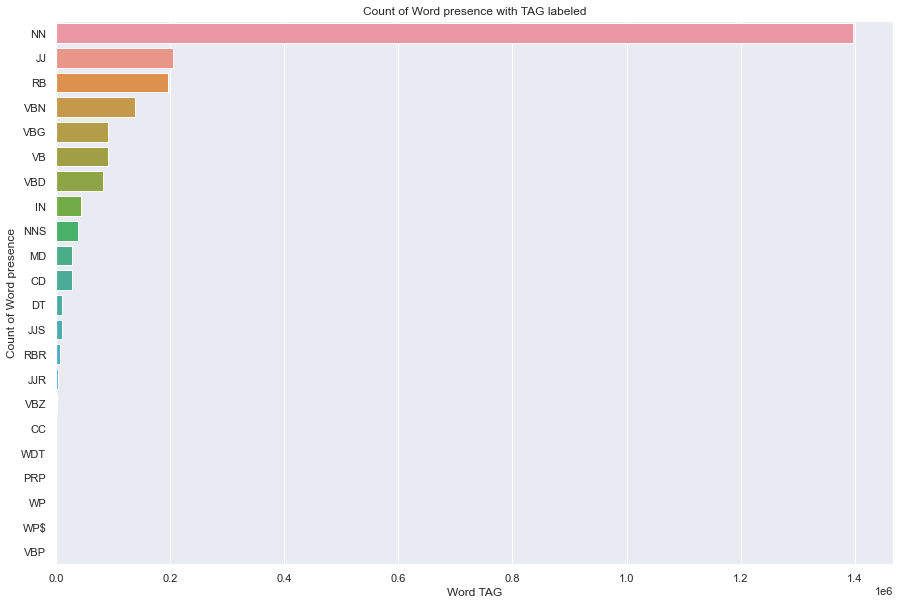

In [18]:
#From the word_frequency dataframe, sum up the words frequency grouping by Tag type
word_tag = pd.DataFrame({'tag_type':word_frequency.groupby('word_tag')['word_count'].sum().index, 'word_tag_count':word_frequency.groupby('word_tag')['word_count'].sum().values})
word_tag.sort_values(by=['word_tag_count'], ascending=False)

#ax1 = sns.displot(data=word_frequency, x=word_frequency.value, kde=False, height=10, aspect=1.5, log_scale=[False,True])
fig, ax = plt.subplots(figsize=(15,10))

#Définir lae type du graphique, ici BARPLOT avec en Labels l'index du nom des libelle
#ax = sns.barplot(data=top_word_frequency, x='word_tag', y=top_word_frequency.groupby('word_tag')['word_count'].sum())
ax = sns.barplot(data=word_tag.sort_values(by=['word_tag_count'], ascending=False) , x='word_tag_count', y='tag_type')

#ax.set_title('Null and NotNull Count per columns in dataframe')
plt.title("Count of Word presence with TAG labeled")
plt.ylabel("Count of Word presence")
plt.xlabel("Word TAG")

#Afficher le graphique
plt.show()


Pour chacun des mots de l'ensemble des reviews collectées, nous avons "taggés" ceux-ci afin d'en définir leur type (Adjectifs, Noms, Adverbes, etc...).

Nous notons sur le graphe ci-dessus, une forte proportion de Noms.

Dans le graphique ci-dessous, nous allons jouer avec la variable **tag_type** pour **comprendre les n_tops mots les plus représentés** en fonction du tag choisi:

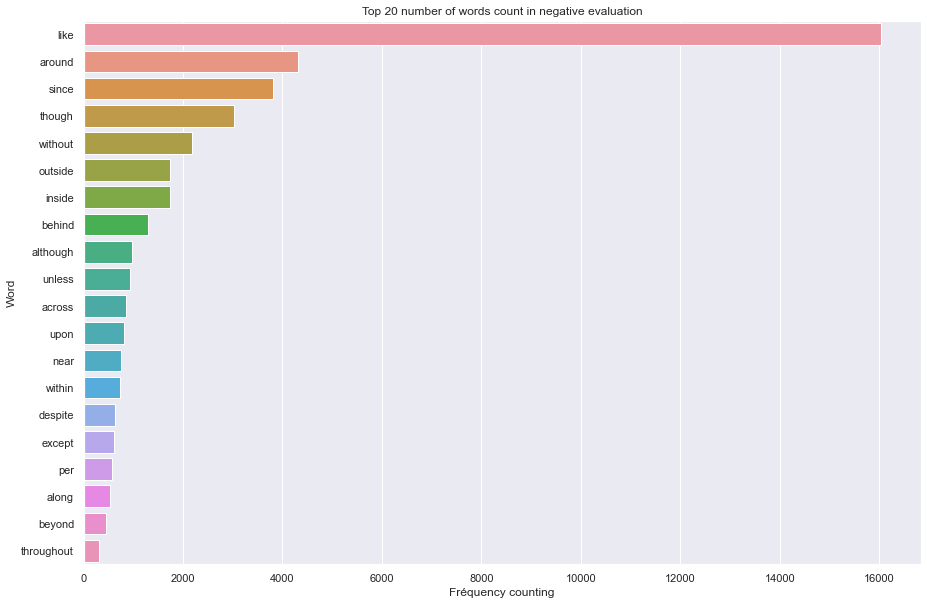

In [19]:
n_tops=20
tag_type = 'IN'
word_frequency.head(n_tops)

#Create a plot to represent n_tops words (Adjectives = JJ) most present in dataframe
fig, ax = plt.subplots(figsize=(15,10))
#Définir lae type du graphique, ici BARPLOT avec en Labels l'index du nom des libelle
ax = sns.barplot(data = word_frequency.loc[((word_frequency['word_tag'] == tag_type)), :].head(n_tops), y='word', x='word_count')
plt.title(f"Top {n_tops} number of words count in negative evaluation")
plt.ylabel("Word")
plt.xlabel("Fréquency counting")
#Afficher le graphique
plt.show()


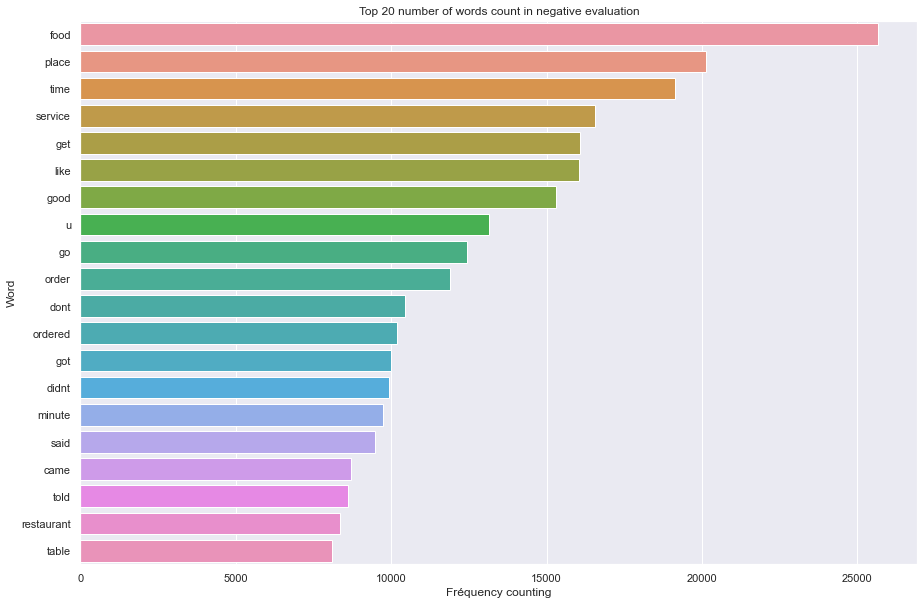

In [20]:
n_tops=20
#tag_type_to_eliminate = ['NN','RB','RBR','IN','VB','VBN','VBG','VBZ','MD','CD','PRP','PRP$']
tag_type_to_eliminate = ['RB','RBR','MD','CD']
word_frequency.head(n_tops)

#Create a plot to represent n_tops words (Adjectives = JJ) most present in dataframe
fig, ax = plt.subplots(figsize=(15,10))
#Définir lae type du graphique, ici BARPLOT avec en Labels l'index du nom des libelle
ax = sns.barplot(data = word_frequency.loc[(word_frequency['word_tag'].isin(tag_type_to_eliminate) == False), :].head(n_tops), y='word', x='word_count')
plt.title(f"Top {n_tops} number of words count in negative evaluation")
plt.ylabel("Word")
plt.xlabel("Fréquency counting")
#Afficher le graphique
plt.show()

#### Visualisation WordCloud
WordCloud et matplotlib.pyplot nous permettront d’afficher un wordcloud basique tandis que numpy et Image vont nous être utiles par la suite pour personnaliser la forme de notre wordcloud.

- Plus d'informations disponible [ici](https://datascientest.com/wordcloud-python)
- [Cours Openclassorooms en anglais](https://openclassrooms.com/fr/courses/6532301-introduction-to-natural-language-processing)

Nous conserverons uniquement les Adjectifs, et afficherons les 50 mots les plus récurrents.

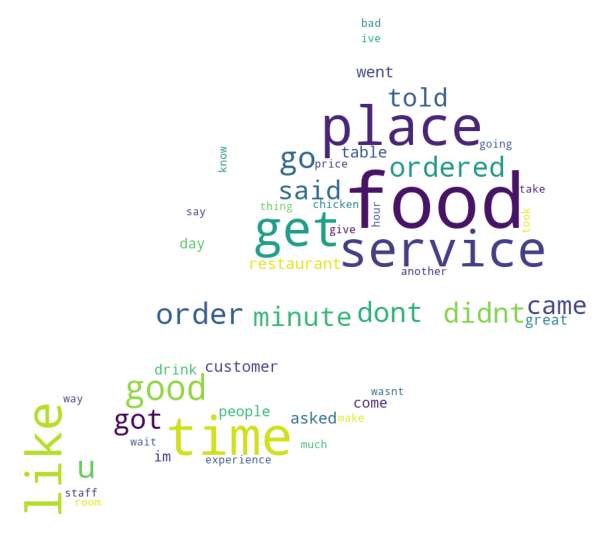

In [21]:
# method 1: convert to dict 
#data_wordcloud = dict(zip(word_frequency['word'].tolist(), word_frequency['word_count'].tolist()))
# method 2: convert to dict
data_wordcloud = word_frequency.loc[word_frequency['word_tag'].isin(tag_type_to_eliminate) == False, :].set_index('word').to_dict()['word_count']

#Load Image Mask
mask = np.array(Image.open("plate.jpg"))
mask[mask == 1] = 255

#We set WordCloud, with max_words = 50
wordcloud = WordCloud(background_color = 'white', max_words = 50, width=800, height=400, mask = mask).generate_from_frequencies(data_wordcloud)
plt.figure( figsize=(15,10) )
plt.imshow(wordcloud)
plt.axis("off")
plt.show();

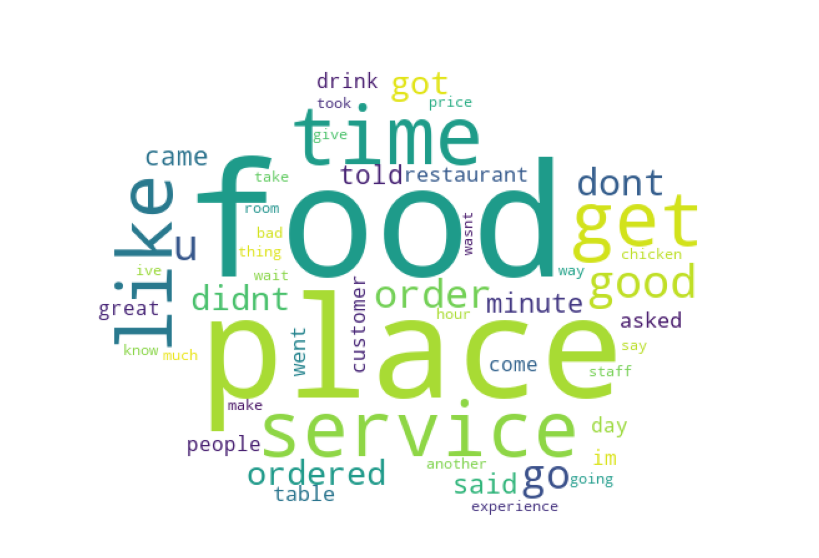

In [127]:
# method 1: convert to dict 
#data_wordcloud = dict(zip(word_frequency['word'].tolist(), word_frequency['word_count'].tolist()))
# method 2: convert to dict
data_wordcloud = word_frequency.loc[word_frequency['word_tag'].isin(tag_type_to_eliminate) == False, :].set_index('word').to_dict()['word_count']

#Load Image Mask
mask = np.array(Image.open("cloud.png"))
mask[mask == 1] = 255

#We set WordCloud, with max_words = 50
wordcloud = WordCloud(background_color = 'white', max_words = 50, width=800, height=400, mask = mask).generate_from_frequencies(data_wordcloud)
plt.figure( figsize=(15,10) )
plt.imshow(wordcloud)
plt.axis("off")
plt.show();

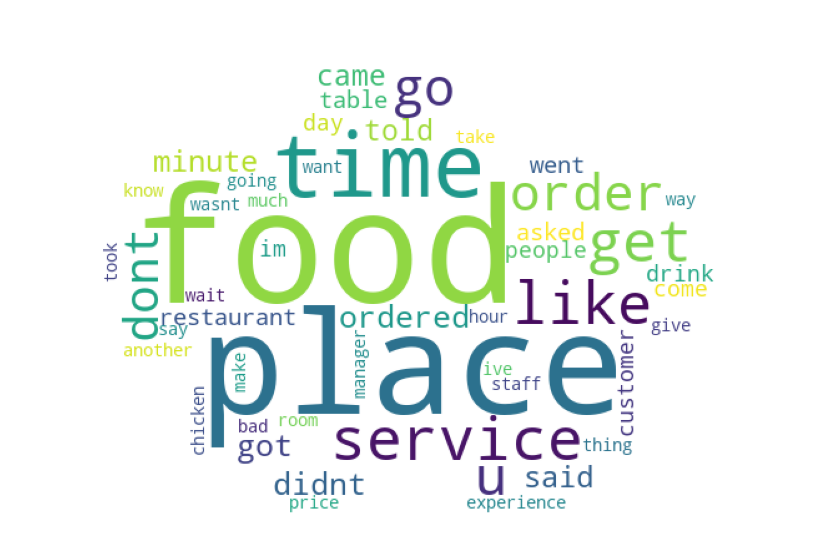

In [128]:
#Load Image Mask
mask = np.array(Image.open("cloud.png"))
mask[mask == 1] = 255

#We remove from data_wordcloud the top 2 adjectives that looks positive evaluation
del data_wordcloud['good']
del data_wordcloud['great']

#We set WordCloud, with max_words = 50
wordcloud = WordCloud(background_color = 'white', stopwords = stopwords, max_words = 50, width=800, height=400, mask = mask).generate_from_frequencies(data_wordcloud)
plt.figure( figsize=(15,10) )
plt.imshow(wordcloud)
plt.axis("off")
plt.show();

Au regard des mots / textes que nous  traitons, nous choisissons de reprendre le pre-processing du jeu de données, pour y inclure la suppressions des Adverbes, Verbes, et Nom.

    tag_type_to_eliminate = ['NN','RB','RBR','IN','MD','CD','PRP','PRP$']

In [22]:
#tag_type_to_eliminate = ['NN','RB','RBR','IN','MD','CD','PRP','PRP$']
tag_type_to_eliminate = ['RB','RBR','MD','CD']

# Change Text column to lower case
unsatisfied_review_df['text'] = unsatisfied_review_df['text'].str.lower()
# Replace punct by blank
unsatisfied_review_df['text'] = unsatisfied_review_df['text'].str.replace(r'[^\w\s]+', '', regex=True)
# Remove numbers digits from text column
unsatisfied_review_df['text_only'] = unsatisfied_review_df['text'].str.replace(r'[\d]+', '', regex=True)
# Words splitting
tokenize_text(unsatisfied_review_df, 'text_only')
#Remove all unecessary tagged words (Adverbs, Verbs, ...)
remove_undesired_wordtag(unsatisfied_review_df, 'tokenized_text', tag_type_to_eliminate)
# Words cleaning
stopwords_text(unsatisfied_review_df, 'removed_tag_text')
lemmatize_text(unsatisfied_review_df, 'stopwords_text')
unsatisfied_review_df.head()


,stars,text,text_only,tokenized_text,stopwords_text,lemmatized_text,thesaurus,removed_tag_text
5,1.0,i am a long term frequent customer of this est...,i am a long term frequent customer of this est...,"[i, am, a, long, term, frequent, customer, of,...","[long, term, frequent, customer, establishment...","[long, term, frequent, customer, establishment...",long term frequent customer establishment went...,"[i, am, a, long, term, frequent, customer, of,..."
29,2.0,i at least have to give this restaurant two st...,i at least have to give this restaurant two st...,"[i, at, least, have, to, give, this, restauran...","[least, give, restaurant, stars, due, decent, ...","[least, give, restaurant, star, due, decent, f...",least give restaurant two star due decent food...,"[i, at, least, have, to, give, this, restauran..."
41,2.0,straight to the point its cheap it tastes and ...,straight to the point its cheap it tastes and ...,"[straight, to, the, point, its, cheap, it, tas...","[point, cheap, tastes, feels, cheap, good, pri...","[point, cheap, taste, feel, cheap, good, price...",straight point cheap taste feel cheap good pri...,"[to, the, point, its, cheap, it, tastes, and, ..."
46,2.0,never again this is a so called restaurant tha...,never again this is a so called restaurant tha...,"[never, again, this, is, a, so, called, restau...","[called, restaurant, nothing, restaurant, prep...","[called, restaurant, nothing, restaurant, prep...",never called restaurant nothing restaurant pre...,"[this, is, a, called, restaurant, that, does, ..."
47,1.0,if you want to pay for everything a la carte t...,if you want to pay for everything a la carte t...,"[if, you, want, to, pay, for, everything, a, l...","[want, pay, everything, la, carte, place, food...","[want, pay, everything, la, carte, place, food...",want pay everything la carte place food wasnt ...,"[if, you, want, to, pay, for, everything, a, l..."


### Extraire les informations du texte
#### Bag of Words
La technique Bag of Words consiste à représenter le document par un ensemble des mots qu'il contient. En pratique, ça peut être par exemple un vecteur de fréquence d'apparition des différents mots utilisés.

Voir [exemple ci-dessous](https://openclassrooms.com/fr/courses/6532301-introduction-to-natural-language-processing/6980811-apply-a-simple-bag-of-words-approach#/id/r-7053954)

Généralement, il faut aller au delà de la tokenisation, afin de séparer le texte en groupes de plusieurs mots. On appelle les groupes de mots les n-grammes (n-gram) : 
 - [bigrammes](https://openclassrooms.com/fr/courses/4470541-analysez-vos-donnees-textuelles/4855001-representez-votre-corpus-en-bag-of-words#/id/r-4855203) pour les couples de mots
 - trigrammes pour les groupes de 3
 - etc. 
 - Séparer en mot unique est en fait un cas particulier appelé unigrammes.

L'utilisation de la fonction [CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) permettra de retourner la matrice de comptage des tokens.
    
Cependant, l'inconvenient de cette technique est qu'il utilise uniquement la fréquence d'apparition des mots (voir [Matrice creuses](https://openclassrooms.com/fr/courses/4470541-analysez-vos-donnees-textuelles/4855001-representez-votre-corpus-en-bag-of-words#/id/r-5174008)). 
Or, si l'on veut représenter les documents dans leur ensemble, nous devons considérer la rareté, et la siungularité du mot.


#### Encodage du texte avec TF-IDF
 
Nous avons d'abord supprimé les mots les plus fréquents de manière générale dans le langage (les fameux stopwords). À présent, il ne faut pas considérer le poids d'un mot dans un document comme sa fréquence d'apparition uniquement, mais pondérer cette fréquence par un indicateur si ce mot est commun ou rare dans tous les documents.

Pour résumer, le poids du n-gramme est le suivant :

    poids=fréquence du terme×indicateur similarité

En l’occurence, la métrique tf-idf (Term-Frequency - Inverse Document Frequency) utilise comme indicateur de similarité l'inverse document frequency qui est l'inverse de la proportion de document qui contient le terme, à l'échelle logarithmique. Il est appelé logiquement « inverse document frequency » (idf). 

Nous calculons donc le poids tf-idf final attribué au n-gramme :

    poids=frequence du n-gram×idf(n-gramme)

In [23]:
from sklearn.feature_extraction.text import TfidfVectorizer

#Extraction des features avec Tf-Idf Vectorizer : min_df=0.01,max_df=0.8 
tfidf = TfidfVectorizer(min_df=0.005,max_df=0.8)

values = tfidf.fit_transform(unsatisfied_review_df['thesaurus'])
print("Created %d X %d TF-IDF-normalized document-term matrix" % (values.shape[0], values.shape[1]) )

values_tfidf = pd.DataFrame(values.toarray())
values_tfidf.head()

Created 38038 X 1546 TF-IDF-normalized document-term matrix


,0,1,2,3,4,5,6,7,8,9,...,1536,1537,1538,1539,1540,1541,1542,1543,1544,1545
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.211858,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.154359,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [24]:
dump(tfidf, './Models/tfidfvectorizer.joblib')
dump(tfidf, './Models/tfidfvectorizer.pkl')

['./Models/tfidfvectorizer.pkl']

### Latent Dirichlet Allocation models
Dans le but d'expliquer des ensembles d’observations à partir des textes associés au insatisfactions, nous réaliseons une LDA (**Allocation de Dirichlet Latente** provenant de l’anglais Latent Dirichlet Allocation).

Plus d'info disponibles ci-dessous:
   - [Page Wikipedia](https://fr.wikipedia.org/wiki/Allocation_de_Dirichlet_latente)
   - [Introduction](https://towardsdatascience.com/latent-dirichlet-allocation-lda-9d1cd064ffa2)
   - [Librairie Sickit Learn](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.LatentDirichletAllocation.html)
   - [Cours OC](https://openclassrooms.com/fr/courses/4470541-analysez-vos-donnees-textuelles/4855011-modelisez-des-sujets-avec-des-methodes-non-supervisees#/id/r-4857692)

Nous entrainons un LDA pour analyser les topics
C’est une méthode non-supervisée générative qui se base sur les hypothèses suivantes :

    Chaque document du corpus est un ensemble de mots sans ordre (bag-of-words) ;
    Chaque document m aborde un certain nombre de thèmes dans différentes proportions qui lui sont propres p(θm)
    Chaque mot possède une distribution associée à chaque thème p(ϕk). On peut ainsi représenter chaque thème par une probabilité sur chaque mot.
    zn représente le thème du mot wn

Puisque l'on a accès uniquement aux documents, on doit déterminer quels sont les thèmes, les distributions de chaque mot sur les thèmes, la fréquence d’apparition de chaque thème sur le corpus.

#### Entrainement du modèle LDA




In [165]:
n_topics = 5

# Créer le modèle LDA
lda_tfidf = LatentDirichletAllocation(n_components=n_topics, random_state=0)

# Fitter sur les données
lda_tfidf.fit(values_tfidf)

LatentDirichletAllocation(n_components=5, random_state=0)

In [166]:
no_top_words = 10
display_topics(lda_tfidf, word_frequency['word'], no_top_words)

Topic 0:
ball hold fire check mean small late disgusting tuna definitely
Topic 1:
chose available chewy broke type often average impressed amazing easy
Topic 2:
available basic clothes uncomfortable chewy broke reasonable stupid past almost
Topic 3:
care unfriendly broke concept husband impressed pm smile management burger
Topic 4:
available amazing le otherwise chose often girlfriend noise today person


#### Visualiser les topics LDA avec pyLDAvis

Nous visualiserons ensuite avec [LDAviz](https://github.com/TomasKeller/python-LDAviz)

In [167]:
pyLDAvis.sklearn.prepare(lda_tfidf, values, tfidf)

C:\Users\blanc\anaconda3\envs\IA_Project6bis\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\blanc\anaconda3\envs\IA_Project6bis\lib\site-packages\pyLDAvis\_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.080030 -0.095454       1        1  30.034209
3     -0.005778  0.112478       2        1  21.311096
2      0.071697  0.022103       3        1  20.948790
1      0.002494  0.005937       4        1  20.688475
0     -0.148442 -0.045065       5        1   7.017430, topic_info=            Term        Freq       Total Category  logprob  loglift
1112        room  667.000000  667.000000  Default  30.0000  30.0000
640        hotel  434.000000  434.000000  Default  29.0000  29.0000
1279        stay  325.000000  325.000000  Default  28.0000  28.0000
112     bathroom  201.000000  201.000000  Default  27.0000  27.0000
368        dirty  274.000000  274.000000  Default  26.0000  26.0000
...          ...         ...         ...      ...      ...      ...
373   disgusting   61.238967  162.587250   Topic5  -5.4668   1.6803
382         door   67.695563  276.822831   Topic5  -5.3666   1.2484
869         nice   69.740969  455.540476   Topic5  -5.3368   0.7801
730         like   73.721842  985.505171   Topic5  -5.2813   0.0639
903          one   66.682258  970.818637   Topic5  -5.3816  -0.0214

[339 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
4         1  0.057983      account
4         2  0.850424      account
4         3  0.038656      account
4         4  0.057983      account
5         2  0.103562  acknowledge
...     ...       ...          ...
1544      1  0.232402        youre
1544      2  0.158033        youre
1544      3  0.079017        youre
1544      4  0.464803        youre
1544      5  0.065072        youre

[1007 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 4, 3, 2, 1])

In [168]:
unsatisfied_review_df.head()

,stars,text,text_only,tokenized_text,stopwords_text,lemmatized_text,thesaurus,removed_tag_text
5,1.0,i am a long term frequent customer of this est...,i am a long term frequent customer of this est...,"[i, am, a, long, term, frequent, customer, of,...","[long, frequent, went, busy, half, full, best,...","[long, frequent, went, busy, half, full, best,...",long term frequent customer establishment went...,"[am, a, long, frequent, this, went, to, out, a..."
29,2.0,i at least have to give this restaurant two st...,i at least have to give this restaurant two st...,"[i, at, least, have, to, give, this, restauran...","[least, stars, due, decent, appetizers, cook, ...","[least, star, due, decent, appetizer, cook, br...",least give restaurant two star due decent food...,"[least, have, to, this, stars, due, to, the, d..."
41,2.0,straight to the point its cheap it tastes and ...,straight to the point its cheap it tastes and ...,"[straight, to, the, point, its, cheap, it, tas...","[cheap, feels, cheap, good, edible, items, chi...","[cheap, feel, cheap, good, edible, item, chick...",straight point cheap taste feel cheap good pri...,"[to, the, cheap, and, feels, cheap, the, good,..."
46,2.0,never again this is a so called restaurant tha...,never again this is a so called restaurant tha...,"[never, again, this, is, a, so, called, restau...","[want, walk, stairs, dirty, dirty, chairs, enj...","[want, walk, stair, dirty, dirty, chair, enjoy...",never called restaurant nothing restaurant pre...,"[this, a, that, a, other, the, the, want, and,..."
47,1.0,if you want to pay for everything a la carte t...,if you want to pay for everything a la carte t...,"[if, you, want, to, pay, for, everything, a, l...","[want, wasnt, terrible, impressive, brought, c...","[want, wasnt, terrible, impressive, brought, c...",want pay everything la carte place food wasnt ...,"[want, to, a, this, the, wasnt, terrible, impr..."


Nous obtenons maintenant les indicateurs permettant d'analyser les 5 topics permettant de classifier composant le texte.
Comme on peut le voir, quelques sujets qui ont été modélisés sont effectivement interprétables : 

 - le sujet 1 représente plutot le service
 - le sujet 2 représent plutot la nourriture
 - le sujet 3 représente plutot l'attente client
 - le sujet 5 représente plutot le lieu

Une autre type de modélisation de sujet automatique non supervisée est NMF (Negative Matrix Factorisation).

### Negative Matrix Factorisation

Voir [Cours OC](https://openclassrooms.com/fr/courses/4470541-analysez-vos-donnees-textuelles/4855011-modelisez-des-sujets-avec-des-methodes-non-supervisees#/id/r-4868071)


In [169]:
from sklearn.decomposition import NMF
from sklearn import decomposition

# Créer le modèle NMF
nmf = NMF(init="nndsvd", n_components=n_topics, random_state=0)
# Fitter sur les données
nmf.fit(values_tfidf)

no_top_words = 10
display_topics(nmf, word_frequency['word'], no_top_words)

Topic 0:
ball unfriendly broke impressed care management easy glass burger concept
Topic 1:
le otherwise often amazing person noise particular today spicy toilet
Topic 2:
basic uncomfortable clothes past almost carry roast reasonable king broke
Topic 3:
girlfriend portion today unfortunately uncomfortable grocery otherwise adult noise chose
Topic 4:
available chewy chose amazing move cheese touch drinking recent average


In [170]:

# create the model, specifiying the initialization strategy and the number of topics to produce
nmf = decomposition.NMF(init="nndsvd", n_components=n_topics, random_state=0) 
# apply the model and extract the two factor matrices
W = nmf.fit_transform(values_tfidf)
H = nmf.components_

In [171]:
descriptors = []
for topic_index in range(n_topics):
    descriptors.append(get_descriptor(word_frequency['word'], H, topic_index, 10 ) )
    str_descriptor = ", ".join(descriptors[topic_index] )
    print("Topic %02d: %s" % ( topic_index, str_descriptor ) )

Topic 00: ball, unfriendly, broke, impressed, care, management, easy, glass, burger, concept
Topic 01: le, otherwise, often, amazing, person, noise, particular, today, spicy, toilet
Topic 02: basic, uncomfortable, clothes, past, almost, carry, roast, reasonable, king, broke
Topic 03: girlfriend, portion, today, unfortunately, uncomfortable, grocery, otherwise, adult, noise, chose
Topic 04: available, chewy, chose, amazing, move, cheese, touch, drinking, recent, average


Ci dessous, vous trouverez ainsi le poid associé aux top 15 mots du Topic 5

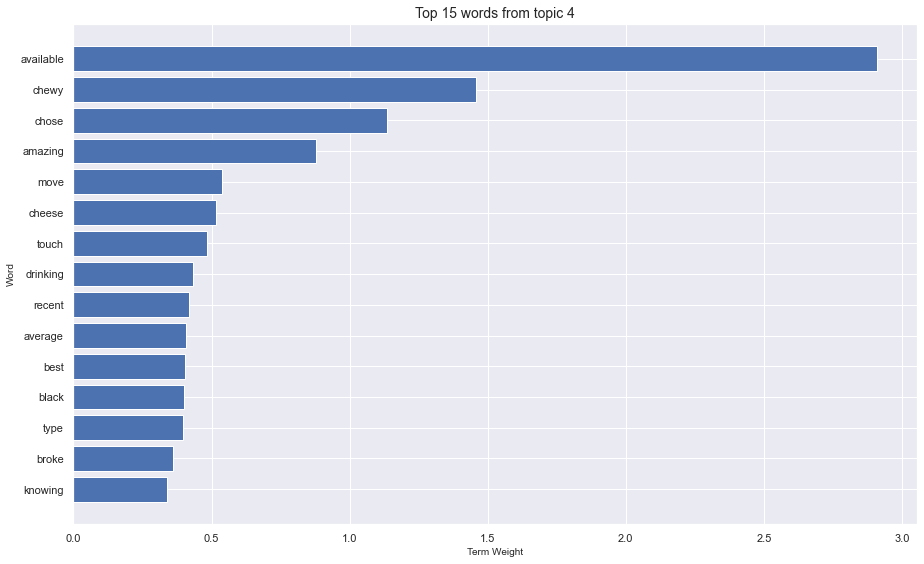

In [172]:
plot_top_term_weights(word_frequency['word'], H, 4, 15)

Nous notons ici que nous constituons 5 Topics différents (Choix arbitraire).

Les comparaisons entre les approches LDA et NMF nous permettent d'évaluer la pertinence des modèles.
Aussi, NMF n'apparait pas pertinente pour la suite de l'analyse NLP, car elle ne permet pas d'entrainer un modèle, et de rajouter des données au fil du temps (Fit et predict sequentiel).




Aussi, nous poursuivrons avec la visualisation du [modèle GENSIM](https://radimrehurek.com/gensim/)

### GENSIM Visualisation
[Exemple de notebook inspirant](https://nbviewer.org/github/bmabey/pyLDAvis/blob/master/notebooks/Gensim%20Newsgroup.ipynb)


Dans un premier temps, nous allons réaliser une étude similaire à LDA, en utilisant les librairies GENSIM.
#### Entrainement du modèle LDA a partir de GENSIM (Rappel = 5 topics)

Ensuite, nous visualiserons avec [LDAVIZ](https://github.com/TomasKeller/python-LDAviz)
Nous vérifierons aussi le [Score de cohérence](https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/) obtenu.


Etudier score U_MASS
-   NLP Natural Language Processing
    -   [NLTK](https://www.nltk.org/) and [Spacy](https://spacy.io/api) : for text processing
    -   [Gensim](https://radimrehurek.com/gensim/auto_examples/index.html) and [pyLDAvis](https://nbviewer.org/github/bmabey/pyLDAvis/blob/master/notebooks/pyLDAvis_overview.ipynb) : for topic modelling and visualisation


In [58]:
# Créer le dictionnaire
dataset = [d.split() for d in unsatisfied_review_df['thesaurus']]
id2word = corpora.Dictionary(dataset)
# Créer le corpus
texts = dataset
corpus = [id2word.doc2bow(text) for text in texts]

tfidf_gensim = models.TfidfModel(corpus)  # step 1 -- initialize a model # fit model
corpus_tfidf = tfidf_gensim[corpus] # apply model to the corpus document
#corpus_tfidf = tfidf.fit_transform(corpus)


In [174]:
# Construire le modèle LDA, avec n_topics = 5 (comme le LDA précedent, mais en utilisant GENSIM)
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=id2word, num_topics=n_topics, random_state=0, update_every=1, chunksize=100, passes=10, alpha='auto', per_word_topics=True)

pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_model, corpus, id2word)
vis

C:\Users\blanc\anaconda3\envs\IA_Project6bis\lib\site-packages\pyLDAvis\_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.125861 -0.187076       1        1  31.665711
3      0.077094  0.244462       2        1  24.423730
4      0.095766  0.153155       3        1  21.715980
1      0.146525 -0.175254       4        1  19.886735
2     -0.445245 -0.035286       5        1   2.307845, topic_info=        Term          Freq         Total Category  logprob  loglift
51      food  25210.000000  25210.000000  Default  30.0000  30.0000
226        u  12939.000000  12939.000000  Default  29.0000  29.0000
23     order  13083.000000  13083.000000  Default  28.0000  28.0000
24     place  20030.000000  20030.000000  Default  27.0000  27.0000
288   minute   9462.000000   9462.000000  Default  26.0000  26.0000
...      ...           ...           ...      ...      ...      ...
675      oil    520.835359   1044.379602   Topic5  -4.6557   3.0731
1825  office    343.217047    914.594146   Topic5  -5.0727   2.7887
850     sale    307.391855   1168.762005   Topic5  -5.1830   2.4333
318      use    308.207604   2186.874263   Topic5  -5.1803   1.8094
674     joke    236.851474    535.132956   Topic5  -5.4437   2.9538

[307 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
3005      5  0.996225  advise
75        1  0.338238    also
75        2  0.304256    also
75        3  0.345226    also
75        4  0.012227    also
...     ...       ...     ...
547       1  0.999710    work
72        1  0.671716   would
72        3  0.135776   would
72        4  0.192471   would
880       2  0.999460   youre

[422 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 4, 5, 2, 3])

In [175]:
# Afficher le Perplexity score
print('\nPerplexity: ', lda_model.log_perplexity(corpus)) # How good the model is. lower the better.

#Afficher le Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=texts, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score by CV is : ', coherence_lda)

coherence_model_lda_u_mass = CoherenceModel(model=lda_model, corpus=corpus, texts=texts, dictionary=id2word, coherence='u_mass')
coherence_u_mass = coherence_model_lda_u_mass.get_coherence()

print('\nCoherence Score by U_MASS is : ', coherence_u_mass)



Perplexity:  -7.820987380210728

Coherence Score by CV is :  0.44427519714247143

Coherence Score by U_MASS is :  -2.272561828117932


## Optimisation des hyper paramètre et Determination des Topics

Dans un second temps, nous allons chercher à optimiser les hyper-parmètres du LDA (afin de déterminer le nombre de topic le plus pertinent)

Pour se faire, nous allons réutiliser le modèle GENSIM LDA:
   - [Voir source StackOverflow](https://stackoverflow.com/questions/17421887/how-to-determine-the-number-of-topics-for-lda)
   - [Voir Gensim - Score de cohérence](https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/#17howtofindtheoptimalnumberoftopicsforlda)
   - [Voir Score de cohérence](https://gardeso.com/python-verification-de-la-coherence-de-modeles-lda)
   - [Coherence score](https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0)


Nous rechercherons ainsi l'optimisation du score de cohérence, au travers de 2 méthodes: CV et U_MASS.


In [25]:
def compute_coherence_values_byCV(dictionary, corpus, texts, limit=15, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=id2word, num_topics=num_topics, random_state=0, update_every=1, chunksize=100, passes=10, alpha='auto', per_word_topics=True)
        #model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=id2word, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

# Calculer les scores de cohérence entre 2 et 40 topics (Cela peut prendre un certain temps)
#model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=1)

def compute_coherence_values_byUMASS(dictionary, corpus, texts, limit=15, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=id2word, num_topics=num_topics, random_state=0, update_every=1, chunksize=100, passes=10, alpha='auto', per_word_topics=True)
        #model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, corpus=corpus, texts=texts, dictionary=id2word, coherence='u_mass')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values



In [133]:
start=3
limit=10
step=1
# Calculer les scores de cohérence entre 3 et 10 topics (Cela peut prendre un certain temps)
model_list_byCV, coherence_values_byCV = compute_coherence_values_byCV(dictionary=id2word, corpus=corpus_tfidf, texts=texts, start=start, limit=limit, step=step)

In [134]:
model_list_byCV

In [135]:
# Affchier les coherence scores
for m, cv in zip(model_list_byCV, coherence_values_byCV):
    print("Model =", m, " has Coherence Value of", round(cv, 4))  #le 4 correspond au nombre de décimales du c

Model = LdaModel(num_terms=52882, num_topics=3, decay=0.5, chunksize=100)  has Coherence Value of 0.3479
Model = LdaModel(num_terms=52882, num_topics=4, decay=0.5, chunksize=100)  has Coherence Value of 0.3516
Model = LdaModel(num_terms=52882, num_topics=5, decay=0.5, chunksize=100)  has Coherence Value of 0.2608
Model = LdaModel(num_terms=52882, num_topics=6, decay=0.5, chunksize=100)  has Coherence Value of 0.2633
Model = LdaModel(num_terms=52882, num_topics=7, decay=0.5, chunksize=100)  has Coherence Value of 0.3156
Model = LdaModel(num_terms=52882, num_topics=8, decay=0.5, chunksize=100)  has Coherence Value of 0.2806
Model = LdaModel(num_terms=52882, num_topics=9, decay=0.5, chunksize=100)  has Coherence Value of 0.2298


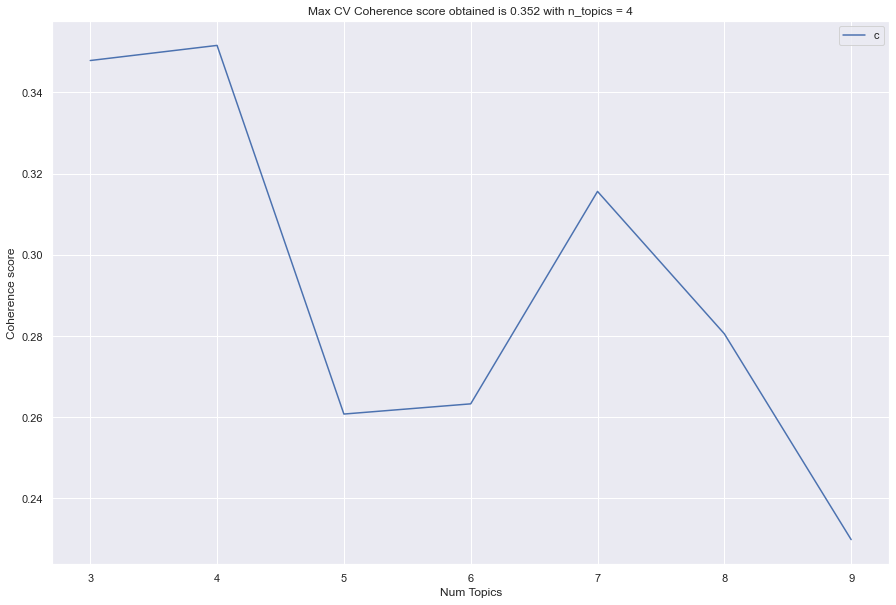

In [136]:
# Afficher un graphique
x = range(start, limit, step)
fig = plt.figure(figsize=(15,10))
plt.plot(x, coherence_values_byCV)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"))
plt.title(f"Max CV Coherence score obtained is {round(max(coherence_values_byCV),3)} with n_topics = {coherence_values_byCV.index(max(coherence_values_byCV))+start}")
plt.show()

Les score de cohérence par CV nous permet de déterminer le nombre de Topics à préviligier.

Généralement, le nombre de topics optimal selon cette mesure correspond au moins grand nombre de topics avant que le score de cohérence ne se mette à baisser (Ici = 4 plutot que 7).
C'est ce que nous avions pu noter avec la méthode du coude.

Note: Il existe également d’autres mesures pour calculer le nombre de topics optimal, Afin de pouvoir réellement établir le nombre de topics optimal à utiliser pour chaque modèle LDA, nous allons étudier le score de cohérence par U_MASS.


In [137]:
start=3
limit=10
step=1
# Calculer les scores de cohérence entre 3 et 10 topics (Cela peut prendre un certain temps)
model_list_byUMASS, coherence_values_byUMASS = compute_coherence_values_byUMASS(dictionary=id2word, corpus=corpus_tfidf, texts=texts, start=start, limit=limit, step=step)

In [138]:
# Affchier les coherence scores
for m, umass in zip(model_list_byUMASS, coherence_values_byUMASS):
    print("Num Topics =", m, " has Coherence Value of", round(umass, 4))  #le 4 correspond au nombre de décimales du c

Num Topics = LdaModel(num_terms=52882, num_topics=3, decay=0.5, chunksize=100)  has Coherence Value of -6.7538
Num Topics = LdaModel(num_terms=52882, num_topics=4, decay=0.5, chunksize=100)  has Coherence Value of -9.4161
Num Topics = LdaModel(num_terms=52882, num_topics=5, decay=0.5, chunksize=100)  has Coherence Value of -8.1463
Num Topics = LdaModel(num_terms=52882, num_topics=6, decay=0.5, chunksize=100)  has Coherence Value of -5.3124
Num Topics = LdaModel(num_terms=52882, num_topics=7, decay=0.5, chunksize=100)  has Coherence Value of -5.2307
Num Topics = LdaModel(num_terms=52882, num_topics=8, decay=0.5, chunksize=100)  has Coherence Value of -4.893
Num Topics = LdaModel(num_terms=52882, num_topics=9, decay=0.5, chunksize=100)  has Coherence Value of -4.7392


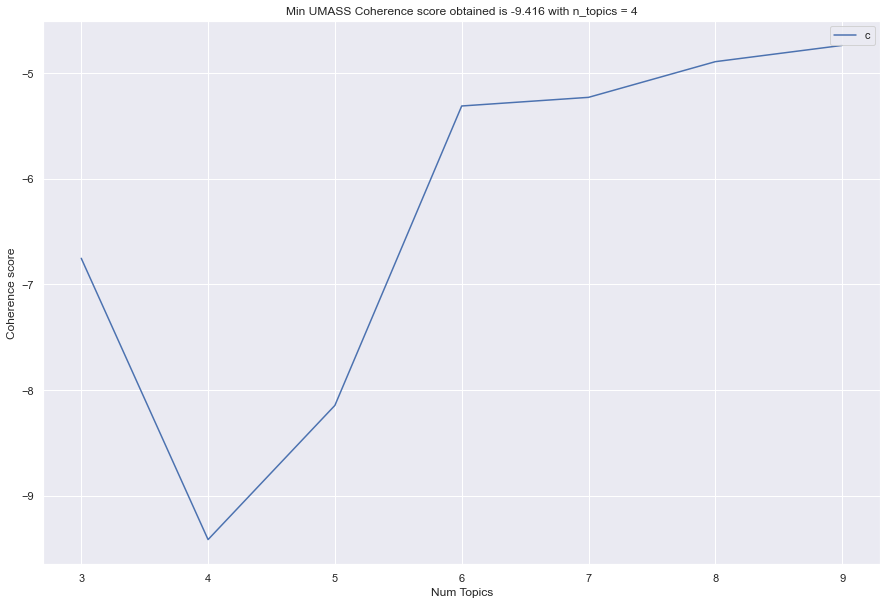

In [139]:
# Afficher un graphique
x = range(start, limit, step)
fig = plt.figure(figsize=(15,10))
plt.plot(x, coherence_values_byUMASS)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"))
plt.title(f"Min UMASS Coherence score obtained is {round(min(coherence_values_byUMASS),3)} with n_topics = {coherence_values_byUMASS.index(min(coherence_values_byUMASS))+start}")
plt.show()

Pour le coherence score calculée avec U_MASS, nous obtenons des valeurs négatives. 

Nous confirmons néanmoins que 4 Topics devraient permettre de classifier au mieux les mots les uns par rapport aux autres.

## Entrainement du modèle avec les 4 topics recommendés par le Coherence Score

### LDA (Topics = 4)

In [26]:
n_topics = 4
# Créer le modèle LDA
lda_tfidf = LatentDirichletAllocation(n_components=n_topics, random_state=0)
# Fitter sur les données
lda_tfidf.fit(values_tfidf)
no_top_words = 10
display_topics(lda_tfidf, word_frequency['word'], no_top_words)
pyLDAvis.sklearn.prepare(lda_tfidf, values, tfidf)

Topic 0:
available amazing le otherwise chose often girlfriend noise today brother
Topic 1:
chose available chewy broke often type work amazing average easy
Topic 2:
available uncomfortable basic clothes chewy broke reasonable almost stupid past
Topic 3:
ball care unfriendly broke concept impressed husband hold glass burger


C:\Users\blanc\anaconda3\envs\IA_Project6bis\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\blanc\anaconda3\envs\IA_Project6bis\lib\site-packages\pyLDAvis\_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.124986 -0.017669       1        1  28.847727
3     -0.115151 -0.008802       2        1  25.167610
1     -0.017362 -0.040000       3        1  23.287328
2      0.007527  0.066470       4        1  22.697335, topic_info=         Term         Freq        Total Category  logprob  loglift
1322    table   644.000000   644.000000  Default  30.0000  30.0000
512      food  1621.000000  1621.000000  Default  29.0000  29.0000
232   chicken   547.000000   547.000000  Default  28.0000  28.0000
823    minute   764.000000   764.000000  Default  27.0000  27.0000
203       car   369.000000   369.000000  Default  26.0000  26.0000
...       ...          ...          ...      ...      ...      ...
903       one   256.935767   970.159605   Topic4  -5.2066   0.1543
359     didnt   215.357284   696.337910   Topic4  -5.3831   0.3094
430      even   218.497459   757.492727   Topic4  -5.3687   0.2397
1525    would   221.672183   945.699867   Topic4  -5.3542   0.0322
976     place   209.487071  1276.870502   Topic4  -5.4108  -0.3246

[295 rows x 6 columns], token_table=      Topic      Freq          Term
term                               
5         2  0.126680   acknowledge
5         3  0.253361   acknowledge
5         4  0.633402   acknowledge
6         2  0.099415  acknowledged
6         3  0.139181  acknowledged
...     ...       ...           ...
1525      4  0.234747         would
1544      1  0.219194         youre
1544      2  0.186548         youre
1544      3  0.513007         youre
1544      4  0.083947         youre

[700 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 4, 2, 3])

In [31]:
def simple_topic_name(row):
    if row['Topic'] == 0:
        val = 'Nourriture, Aliments et Gouts'
    elif row['Topic'] == 1:
        val = 'Réservation'
    elif row['Topic'] == 2:
        val = 'Bar et boissons'
    else:
        val = 'Temps d attente et Service'
    return val


In [27]:
#lda_tfidf
#lda_tfidf.components_
#values_tfidf
#pd.DataFrame(values.toarray())
values_tfidf = pd.DataFrame(values.toarray())
topic_result_df = pd.DataFrame(lda_tfidf.transform(values_tfidf)).idxmax(axis=1)
#values_tfidf.head()
df_results = pd.concat([unsatisfied_review_df.loc[:, ['stars', 'text']].reset_index(drop=True), pd.DataFrame(lda_tfidf.transform(values_tfidf)).reset_index(drop=True)], axis = 1)
df_results['Topic'] = topic_result_df
df_results['Topic_name'] = df_results.apply(simple_topic_name, axis=1)
df_results

In [33]:

df_results['Topic_name'] = df_results.apply(simple_topic_name, axis=1)
df_results

,stars,text,0,1,2,3,Topic,Topic_name
0,1.0,i am a long term frequent customer of this est...,0.048141,0.851809,0.050754,0.049296,1,Réservation
1,2.0,i at least have to give this restaurant two st...,0.048930,0.045696,0.859337,0.046037,2,Bar et boissons
2,2.0,straight to the point its cheap it tastes and ...,0.889380,0.039621,0.035980,0.035019,0,"Nourriture, Aliments et Gouts"
3,2.0,never again this is a so called restaurant tha...,0.043753,0.869885,0.042910,0.043451,1,Réservation
4,1.0,if you want to pay for everything a la carte t...,0.526079,0.036791,0.400338,0.036792,0,"Nourriture, Aliments et Gouts"
...,...,...,...,...,...,...,...,...
38033,2.0,the whole place has just a few souvenir stores...,0.060190,0.820500,0.059149,0.060161,1,Réservation
38034,2.0,sorry spiros i didnt want to say anything bad ...,0.037490,0.037322,0.888587,0.036602,2,Bar et boissons
38035,1.0,this place sucks we ordered food for delivery...,0.805584,0.040710,0.041809,0.111897,0,"Nourriture, Aliments et Gouts"
38036,1.0,i spoke with keri about a month ago on the pho...,0.032661,0.033263,0.033519,0.900558,3,Temps d attente et Service


In [31]:
topic_result_df

0        1
1        2
2        0
3        1
4        0
        ..
38033    1
38034    2
38035    0
38036    3
38037    3
Length: 38038, dtype: int64

In [ ]:
#df['Topic_name'] = df.apply(simple_topic_name, axis=1)
df['Topic_name'] = np.where(((df['Topic'] == 0)) | ( (df['gender'] == 'female') & (df['pet1'].isin(['cat','dog'] ) ) ), 5, 0)
df


Nous notons ici que les Topics sont représentés sur un espace à 2 dimensions.

La largeur des Cercle correspond à la fréquence représentée par ce topic dans le document. (Ici nous voyons que la population des topics est equilibrée).

La distance entre ces cercle est une représentation des relations entre ces Topics.
C'est la raison pour laquelle les Topics partageant des mots communs seront superposés.

Interpretation des 4 Topics LDA:

    - Topic 1 : Nourriture, Aliments et Gouts
    - Topic 2 : Réservation
    - Topic 3 : Bar et boissons
    - Topic 4 : Temps d'attente et Service


### NMF (Topics = 4)

In [24]:
#pd.DataFrame(W)
#pd.DataFrame(H)

In [25]:
# Créer le modèle NMF
nmf = NMF(init="nndsvd", n_components=n_topics, random_state=0)
# Fitter sur les données
nmf.fit(values_tfidf)

no_top_words = 10
display_topics(nmf, word_frequency['word'], no_top_words)

# create the model, specifiying the initialization strategy and the number of topics to produce
nmf = decomposition.NMF(init="nndsvd", n_components=n_topics, random_state=0) 
# apply the model and extract the two factor matrices
W = nmf.fit_transform(values_tfidf)
H = nmf.components_


Topic 0:
ball unfriendly broke impressed management easy care glass burger concept
Topic 1:
available amazing chose often le otherwise crispy person touch best
Topic 2:
basic uncomfortable clothes available past chewy carry almost broke reasonable
Topic 3:
girlfriend today portion uncomfortable unfortunately otherwise noise grocery adult often


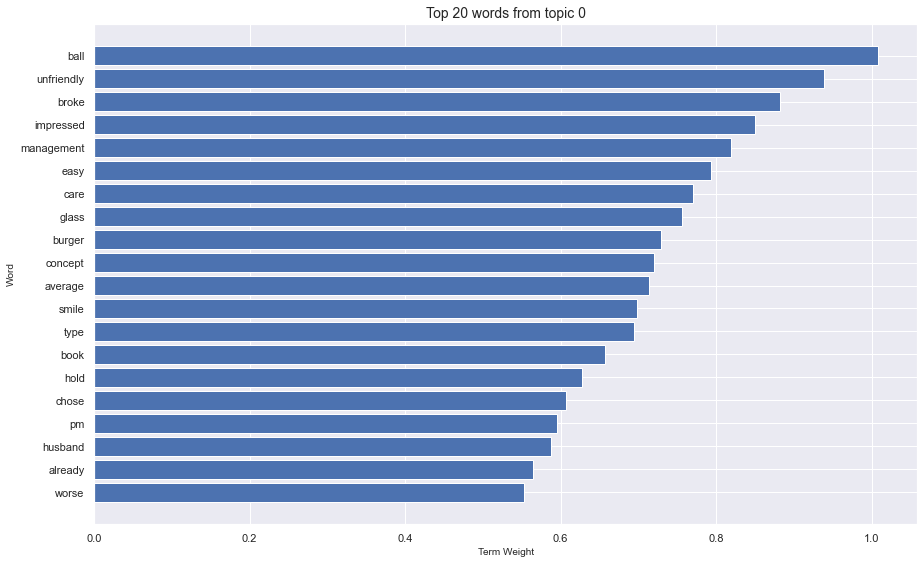

In [26]:
plot_top_term_weights(word_frequency['word'], H, 0, 20)

Au regard des Topics crés par le modèle NMF, il apparait particulièrement complexe d'interpréter ceux-ci.

En effet, la répartition des mots ne démontre pas de catégorie évidente.

### GENSIM (Topics = 4)

In [29]:
n_topics = 4 #coherence_values.index(max(coherence_values))+start

# Créer le dictionnaire
dataset = [d.split() for d in unsatisfied_review_df['thesaurus']]
id2word = corpora.Dictionary(dataset)
# Créer le corpus
texts = dataset
corpus = [id2word.doc2bow(text) for text in texts]

tfidf_gensim = models.TfidfModel(corpus)  # step 1 -- initialize a model # fit model
corpus_tfidf = tfidf_gensim[corpus] # apply model to the corpus document
#corpus_tfidf = tfidf.fit_transform(corpus)

# Construire le modèle LDA, avec n_topics = 8 (comme le LDA précedent, mais en utilisant GENSIM)
lda_gensim = gensim.models.ldamodel.LdaModel(corpus=corpus_tfidf, id2word=id2word, num_topics=n_topics, random_state=0, update_every=1, chunksize=100, passes=10, alpha='auto', per_word_topics=True)

pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_gensim, corpus_tfidf, id2word)
vis

C:\Users\blanc\anaconda3\envs\IA_Project6bis\lib\site-packages\pyLDAvis\_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.312133  0.013865       1        1  90.204313
3      0.143344  0.093051       2        1   7.257166
1      0.085441 -0.047442       3        1   2.420235
2      0.083348 -0.059474       4        1   0.118286, topic_info=                Term        Freq       Total Category  logprob  loglift
313         sandwich  151.000000  151.000000  Default  30.0000  30.0000
670             dish  114.000000  114.000000  Default  29.0000  29.0000
325             fish  113.000000  113.000000  Default  28.0000  28.0000
123           shrimp  102.000000  102.000000  Default  27.0000  27.0000
111             meat   99.000000   99.000000  Default  26.0000  26.0000
...              ...         ...         ...      ...      ...      ...
4365         restore    0.005789    5.730071   Topic4 -10.7091  -0.1578
52871     behindjust    0.005783    5.675723   Topic4 -10.7101  -0.1493
52872  moredifferent    0.005783    5.675723   Topic4 -10.7101  -0.1493
52873     tasteasian    0.005783    5.675723   Topic4 -10.7101  -0.1493
52874       ussually    0.005783    5.675723   Topic4 -10.7101  -0.1493

[214 rows x 6 columns], token_table=       Topic      Freq        Term
term                              
2          1  0.998610        back
911        2  0.988799        bean
685        2  0.994689        beef
52871      1  0.704756  behindjust
52871      2  0.176189  behindjust
...      ...       ...         ...
52866      1  0.721122    wereonce
52866      2  0.288449    wereonce
52866      3  0.144224    wereonce
1886       2  0.987225        wish
72         1  0.999029       would

[162 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 4, 2, 3])

Nous notons ici que les Topics sont représentés sur un espace à 2 dimensions.

La largeur des Cercle correspond à la fréquence représentée par ce topic dans le document. (Ici nous voyons que les topics 1, 2 sont les plus représentés).

La distance entre ces cercle est une représentation des relations entre ces Topics.
C'est la raison pour laquelle les Topics partageant des motc communs seront superposés.


## Persistence des modèles

Afin de conserver et réutiliser les modèles entrainés, pour l'acquisition et le traitement de nouvelles données, nous conservons nos modèles en utilisant la librairie 

   Pour LDA = [Joblib](https://scikit-learn.org/stable/model_persistence.html?highlight=persistence).
   
   Pour NMF = [Joblib](https://scikit-learn.org/stable/model_persistence.html?highlight=persistence).
   
   Pour GENSIM = [Pickle](https://radimrehurek.com/gensim/models/ldamodel.html#gensim.models.ldamodel.LdaModel.save) ou [Pickle](https://docs.python.org/3/library/pickle.html)

In [28]:
#tfidf = TfidfVectorizer(min_df=0.005,max_df=0.8)
#values = tfidf.fit_transform(unsatisfied_review_df['thesaurus'])

dump(tfidf, './Models/tfidfvectorizer.pkl')
dump(tfidf, './Models/tfidfvectorizer.joblib')

dump(tfidf_gensim, './Models/tfidf_gensim.pkl')
dump(tfidf_gensim, './Models/tfidf_gensim.joblib')

# Persistence du modèle LDA   #lda_tfidf.fit(values_tfidf)
dump(lda_tfidf, './Models/lda_tfidf.joblib')

# Persistence du modèle NMF   #nmf.fit(values_tfidf)
dump(nmf, './Models/nmf.joblib')

# Persistence du modèle lda_gensim   #lda_gensim = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=id2word, num_topics=n_topics, random_state=0, update_every=1, chunksize=100, passes=10, alpha='auto', per_word_topics=True)
#A regarder : https://radimrehurek.com/gensim/models/ldamodel.html#gensim.models.ldamodel.LdaModel.save
dump(lda_gensim, './Models/lda_gensim.joblib')
lda_gensim.save('./Models/lda_gensim.model')

[Interpretation des topics](https://gensimr.news-r.org/articles/coherence.html#interpreting-the-topics)

[7. Inference-Using Our Model For New Samples](https://towardsdatascience.com/my-first-nlp-pipeline-99d24aafb773)

## Utilisation de l'API YELP et transformation par Pipeline

Ici, nous testons la récupération de données via l'API.
Nous développerons cette fonctionalité au travers d'un Notebook dédié.


### Récupération de données par API
Les endpoints API Fusion sont accessibles à l'adresse suivante: https://api.yelp.com/v3

Des exemples de codes d'appel aux API sont accessible ici: https://github.com/Yelp/yelp-fusion#code-samples


In [190]:
# Load environment variables from .env file
import os
from dotenv import load_dotenv
load_dotenv("API_key.env")  # take environment variables from .env.
YELP_CLIENT_ID = os.getenv("YELP_CLIENT_ID")
YELP_API_KEY = os.getenv("YELP_API_KEY")

In [191]:
api_key =  YELP_API_KEY
# define our authentication process.
header = {'Authorization': 'bearer {}'.format(api_key), 'Content-Type':"application/json"}

# Build the request framework
transport = RequestsHTTPTransport(url='https://api.yelp.com/v3/graphql', headers=header, use_json=True)

# Create the client
client = Client(transport=transport, fetch_schema_from_transport=True)

In [192]:
# define a simple query

query = gql('''
{
  t1: search(term:"burger", location:"san francisco", offset: 50) {
    business {
      name
      reviews {
        rating
        text
      }
    }
  }
  t2: search(term:"hot dog", location:"los angeles", offset: 50) {
    business {
      name
      reviews {
        rating
        text
      }
    }
  }
  t3: search(term:"fries", location:"miami", offset: 50) {
    business {
      name
      reviews {
        rating
        text
      }
    }
  }
}
''')

# execute and print this query
print('-'*100)
json_string = client.execute(query)
#print(json_string)

import json
with open('./API_Extract/data1.json', 'w', encoding='utf-8') as f:
    json.dump(json_string, f, ensure_ascii=False, indent=4)
    result1 = json.dumps(json_string, indent = 4, sort_keys=True)
print(result1)
#print(json.dumps(json_string))

----------------------------------------------------------------------------------------------------
{
    "t1": {
        "business": [
            {
                "name": "Mission Street Burgers",
                "reviews": [
                    {
                        "rating": 5,
                        "text": "HIGHLY recommend!!\n\nOrdered via Doordash and everything was *excellent*!!!  The breading on their chicken tenders is fire & the burger was suuuuper..."
                    },
                    {
                        "rating": 3,
                        "text": "We ordered via grubhub, the delivery was smooth\n\nThe food however...\nPros: cheeseburger was good, fries are great\n\nCons: we ordered 2 lettuce wrap burgers..."
                    },
                    {
                        "rating": 2,
                        "text": "This seems to me more of a bar which serves food and does have a good patio area.  \n\nThe group I was with all ordered burgers an

In [193]:
# define a simple query

query = gql('''
{
  l1: search(location: "paris") {
    business {
      name
      reviews {
        rating
        text
      }
    }
  }
  l2: search(location: "new-york") {
    business {
      name
      reviews {
        rating
        text
      }
    }
  }
  l3: search(location: "london") {
    business {
      name
      reviews {
        rating
        text
      }
    }
  }
  l4: search(location: "canberra") {
    business {
      name
      reviews {
        rating
        text
      }
    }
  }
}
''')

# execute and print this query
print('-'*100)
json_string = client.execute(query)
#print(json_string)

import json
with open('./API_Extract/data2.json', 'w', encoding='utf-8') as f:
    json.dump(json_string, f, ensure_ascii=False, indent=4)
    result2 = json.dumps(json_string, indent = 4, sort_keys=True)
print(result2)
#print(json.dumps(json_string))

----------------------------------------------------------------------------------------------------


TransportQueryError: {'message': 'Something went wrong internally, please try again later.', 'locations': [{'line': 5, 'column': 7}], 'path': ['l1', 'business', 0, 'reviews'], 'extensions': {'code': 'INTERNAL_ERROR'}}

Nos requetes permetttent donc d'extraire :

    - Première requetes = 180 review max (réparties sur 3 villes = 60 review par ville max, en prenant en compte les contraientes des termes)
    - Second requetes = 240 review au total (réparties sur 4 villes = 60 review par ville)
    
Dans la suite de l'exercice autour des APIs, nous allons créer une boucle permettant de répeter les appels à l'API, afin d'en consolider les résultats, dans un fchier JSON et CSV.

In [ ]:
#print(json_string)
print(type(json_string['l1']['business']))

#print(json_string['l1'])
print(json_string['l1']['business'][0])

In [ ]:
#Lecture des données enregistrées dans le json2
with open('./API_Extract/data2.json', encoding='utf-8') as f:
    d2 = json.load(f)

#Lecture des données enregistrées dans le json1
with open('./API_Extract/data1.json', encoding='utf-8') as f:
    d1 = json.load(f)

#Création d'un dataframe vide
df_api = pd.DataFrame(columns=['rating', 'text'])

#Boucle sur chaqune des 20 reviews, sur chaque ville, pour les 2 dataframe lues à partir des json
for i in range(0, 20, 1):
    #print(i)
    raw1 = json_normalize(d1['t1']['business'][i]['reviews'])
    raw2 = json_normalize(d2['l1']['business'][i]['reviews'])
    df_api = pd.concat([df_api, raw1, raw2], ignore_index = True, axis = 0)
    
for i in range(0, 20, 1):
    #print(i)
    raw1 = json_normalize(d1['t2']['business'][i]['reviews'])
    raw2 = json_normalize(d2['l2']['business'][i]['reviews'])
    df_api = pd.concat([df_api, raw1, raw2], ignore_index = True, axis = 0)
for i in range(0, 20, 1):
    #print(i)
    raw1 = json_normalize(d1['t3']['business'][i]['reviews'])
    raw2 = json_normalize(d2['l3']['business'][i]['reviews'])
    df_api = pd.concat([df_api, raw1, raw2], ignore_index = True, axis = 0)
for i in range(0, 20, 1):
    #print(i)
    raw2 = json_normalize(d2['l4']['business'][i]['reviews'])
    df_api = pd.concat([df_api, raw2], ignore_index = True, axis = 0)
df_api.sort_values('rating', ascending= True).head(3)

In [ ]:
plot_ntops_pie(df_api, 'rating', 5, False, False)

## Réduction de dimenion
Utilisation de T-SNE:

[Page Wikipedia](https://fr.wikipedia.org/wiki/Algorithme_t-SNE)

[Doc Sickit Learn](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html)

L’utilisation des techniques de réduction de la dimension est complète si :

    une méthode de réduction de dimension a été appliquée sur les données texte et sur les données images
    L’utilisation des techniques de réduction de la dimension est pertinente si :
        ❒ une justification du fait d’appliquer une réduction de dimension sur les données texte et image a été donnée
        ❒ une justification des choix des valeurs des paramètres dans la méthode de réduction de dimension retenue a été donnée (ex. : le nombre de dimensions conservées pour l'ACP)